<div style="text-align: center;">
    <h1>Obesity Classification using ML</h1>
</div>


# Importing Libraries

In [599]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_predict,cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer,accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import graphviz
import optuna
warnings.filterwarnings("ignore")

# Problem & Data Definition 

## Problem Statement

- The current obesity crisis is a significant global health issue, leading to numerous deaths annually and affecting overall well-being. 
- Obesity is complex, often recurring, and varies among individuals. 
- Recognized as a chronic disease by organizations like the World Obesity Federation (WOF) and the World Heart Federation (WHF), it poses a heightened risk of cardiovascular problems and mortality. 
- Excess body fat, especially around the abdomen, is closely associated with cardiovascular diseases through various physiological pathways.
- The goal is to develop a multiclass classification model to predict the risk of obesity for individuals based on their physical characteristics, lifestyle and dietary habits. The dataset contains various attributes such as gender, age, height, weight, family history of overweight, dietary habits, physical activity levels, and more. 
- The objective is to accurately classify individuals into one of seven obesity risk categories based on their data.

## Data Definition
- This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. 
- The data contains 17 attributes , the records are labeled with the class variable NObesity (Obesity Level), using the labels of Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.

 Here's a description of the columns in the dataset:

| Feature                                   | Datatype     | Labels                                         | Description                                                |
|-------------------------------------------|--------------|------------------------------------------------|------------------------------------------------------------|
| ID                                        | Categorical  | -                                              | Unique identifier                                          |
| Smoke                                     | Categorical  | Yes, No                                       | Smoker or not                                              |
| Weight                                    | Numerical    | -                                              | Weight (Float)                                             |
| Age                                       | Numerical    | -                                              | Age (Float)                                                |
| Height                                    | Numerical    | -                                              | Height (Float)                                             |
| Gender                                    | Categorical  | Male, Female                                  | Gender                                                     |
| Family_history_with_overweight            | Categorical  | Yes, No                                       | Family history with overweight                             |
| FAVC                                      | Categorical  | Yes, No                                       | Frequent consumption of high-caloric food items            |
| FCVC                                      | Numerical    | -                                              | Frequency of consuming vegetables (Float)                  |
| NCP                                       | Numerical    | -                                              | Number of main meals consumed per day (Float)              |
| CAEC                                      | Categorical  | Sometimes, No, Frequently, Always            | Frequency of consuming food between meals                  |
| CH20                                      | Numerical    | -                                              | Amount of water consumed daily (Float)                     |
| CALC                                      | Categorical  | Sometimes, No, Frequently                    | Frequency of alcohol consumption                           |
| SCC                                       | Categorical  | Yes, No                                       | Monitoring of calorie consumption                          |
| FAF                                       | Numerical    | -                                              | Frequency of engaging in physical activity (Float)         |
| TUE                                       | Numerical    | -                                              | Time spent using technology devices (Float)                |
| MTRANS                                    | Categorical  | Automobile, Bike, Motorbike, Public_Transportation, Walking | Mode of transportation used                              |
| NObeyesdad                                | Categorical  | Underwright, Normal, two levels of Overweight ,three levels of Obesity                                  | Categorizes individuals into different weight or obesity categories (TARGET) |


In [600]:
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# Splitting the Data

In [601]:
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

In [602]:
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y,test_size=0.2, random_state=42) 
# stratify = y to keep the same distribution among train and validation

In [603]:
target_order=['Insufficient_Weight','Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II' ,'Obesity_Type_III']

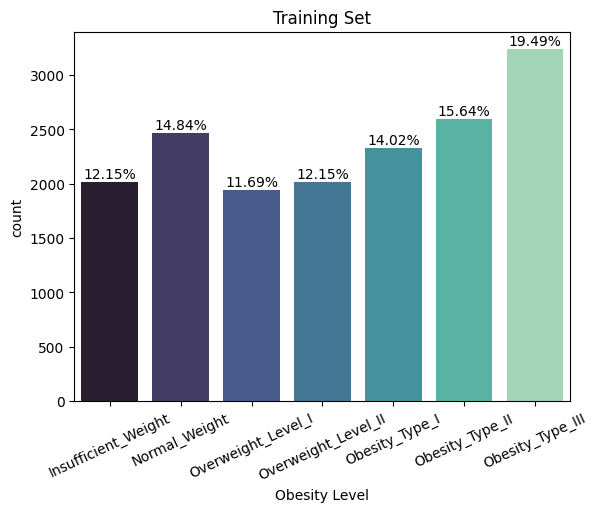

In [604]:
ax = sns.countplot(x=y_train,order= target_order, palette='mako')
total = float(len(y_train))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.002 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Obesity Level')
plt.title('Training Set')
plt.xticks(rotation=25)
plt.savefig('my_plot.png', transparent=True,bbox_inches='tight')
plt.show()

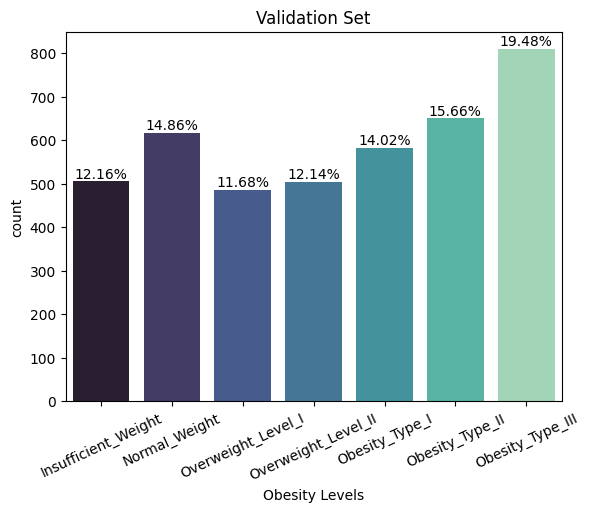

In [605]:
ax = sns.countplot(x=y_test,order= target_order, palette='mako')
total = float(len(y_test))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.002 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Obesity Levels')
plt.title('Validation Set')
plt.xticks(rotation=25)
plt.show()

- We got the same data distributions among the training and testing sets.

In [606]:
# Training Dataset
train_df = pd.concat((X_train,y_train),axis=1)

In [607]:
# Validation Dataset
test_df = pd.concat((X_test,y_test),axis=1)

In [608]:
print(f'The train Dataset has {train_df.shape[0]} row, and {train_df.shape[1]} column.')
print(f'The validation Dataset has {test_df.shape[0]} row, and {test_df.shape[1]} column.')

The train Dataset has 16606 row, and 18 column.
The validation Dataset has 4152 row, and 18 column.


In [609]:
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
4515,4515,Male,22.000000,1.710000,90.000000,yes,yes,2.000000,1.000000,Sometimes,no,2.000000,no,1.000000,2.000000,Sometimes,Public_Transportation,Obesity_Type_I
7949,7949,Female,41.000000,1.640000,77.000000,yes,yes,3.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Automobile,Obesity_Type_I
20677,20677,Male,18.000000,1.800000,56.000000,yes,yes,2.000000,4.000000,Frequently,no,2.000000,no,2.000000,1.000000,no,Automobile,Insufficient_Weight
18079,18079,Male,18.000000,1.700000,85.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Overweight_Level_II
5129,5129,Male,22.735328,1.849425,121.657979,yes,yes,2.352323,2.699971,Sometimes,no,2.357978,no,1.684582,0.739609,Sometimes,Public_Transportation,Obesity_Type_II


# Exploratory Data Analysis (EDA)

In [610]:
train_df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000
mean,10378.111767,23.839810,1.699990,87.863797,2.446339,2.757067,2.029559,0.975859,0.616871
std,6007.850447,5.666853,0.087491,26.423177,0.532595,0.708982,0.607527,0.836036,0.601994
min,0.000000,14.000000,1.450000,39.101805,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5167.750000,20.000000,1.631576,66.000000,2.000000,3.000000,1.796294,0.006265,0.000000
50%,10410.000000,22.783646,1.700000,84.064875,2.392665,3.000000,2.000000,1.000000,0.573887
75%,15600.750000,26.000000,1.762515,111.635463,3.000000,3.000000,2.549617,1.582428,1.000000
max,20757.000000,56.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


- Age: The age of individuals varies between 14 and 61 years, with an average age of 23 years.
- Height: Heights range from 1.45 meters to 1.97 meters, with an average height around 1.7 meters.
- Weight: Individuals' weights range from 39 kg too 165 kg, with an average weight of 87 kg.
- FCVC (Frequency of consumption of vegetables): The frequency of consuming vegetables ranges from 1 to 3 times, with an average frequency of 2.39 times.
- NCP (Number of main meals consumed per day): The number of main meals consumed per day varies from 1 to 4, with an average of 3 meals.
- CH2O (Daily water consumption in liters): Daily water consumption ranges from 1 to 3 liters, with an average of 2 liters.
- FAF (Physical activity frequency): Physical activity frequency ranges from 0 to 3, with an average frequency of 1.
- TUE (Time spent using technological devices): The time spent using technological devices ranges from 0 to 2, with an average of 1 hour.

In [611]:
# We have 7 different categories 
# Underwright, normal, two levels of overweight , and three levels of obesity
train_df['NObeyesdad'].unique()

array(['Obesity_Type_I', 'Insufficient_Weight', 'Overweight_Level_II',
       'Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III',
       'Normal_Weight'], dtype=object)

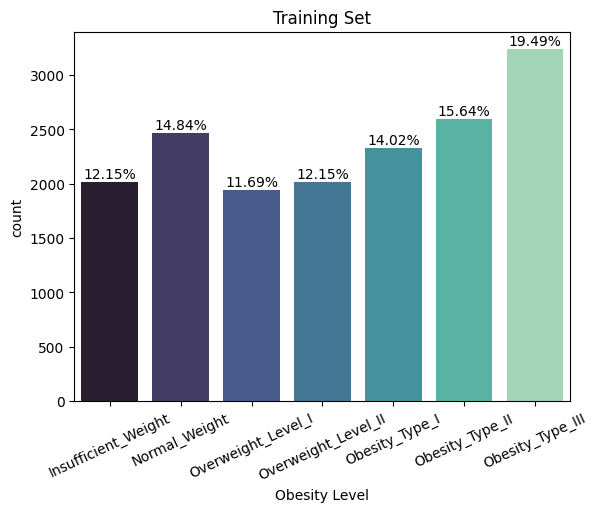

In [591]:
ax = sns.countplot(x=train_df['NObeyesdad'],order= target_order, palette='mako')
total = float(len(train_df['NObeyesdad']))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.002 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 
plt.title('Training Set')
plt.xlabel('Obesity Level')
plt.xticks(rotation=25)
plt.show()
# Not severely imbalanced dataset

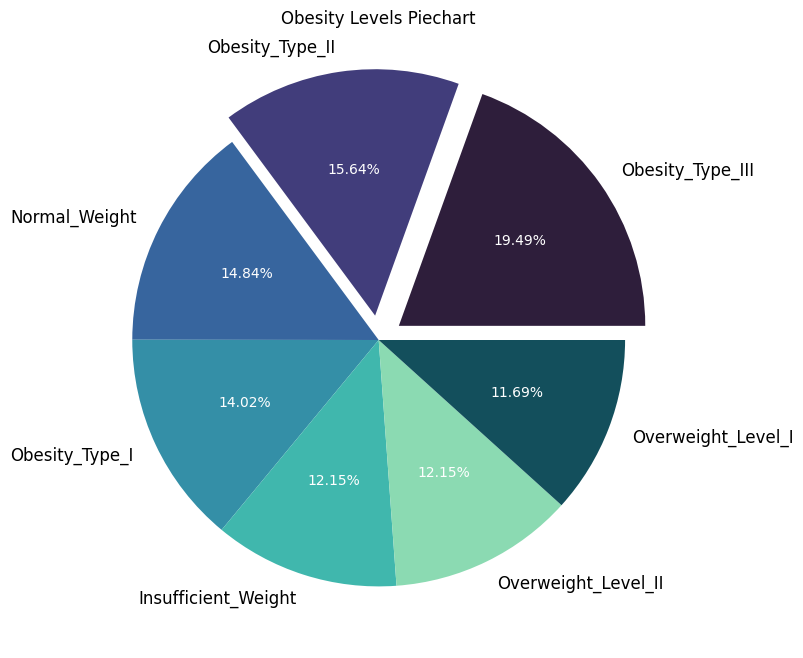

In [592]:
colors = sns.color_palette("mako")+ ['#134f5c']
sns.set_palette(colors)
ser = train_df["NObeyesdad"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,8))
explode = [0.1 if index in ser[:2].index else 0 for index in ser.index]

wedges, texts, autotexts = plt.pie(x=ser.values, labels=ser.index, autopct="%0.2f%%", textprops={'color': 'white'},explode=explode)

for text in texts:
    text.set_fontsize(12)
    text.set_color('black')  
plt.savefig('pie.png', transparent = True)
plt.title('Obesity Levels Piechart')
plt.show()

- Obesity Type III has the the highest number of obesrvations, followed by Obesity Type II.

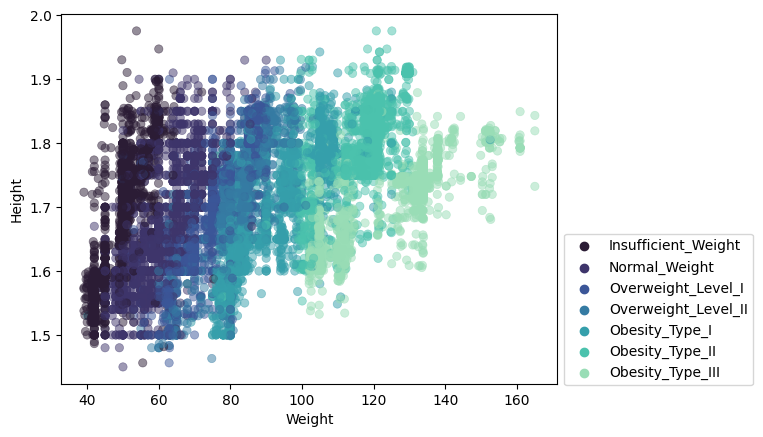

In [593]:
sns.scatterplot(x='Weight', y='Height', hue='NObeyesdad', data=train_df, palette='mako',edgecolor=None,alpha=0.5,hue_order=target_order)
plt.legend(bbox_to_anchor=(1,0.425))
plt.show()

#### Checking the reasonability of the values in each column


In [75]:
train_df['FAVC'].unique()

array(['yes', 'no'], dtype=object)

In [76]:
train_df['CALC'].unique()

array(['Sometimes', 'no', 'Frequently'], dtype=object)

In [77]:
train_df['CAEC'].unique()

array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object)

In [78]:
train_df['NObeyesdad'].unique()

array(['Obesity_Type_I', 'Insufficient_Weight', 'Overweight_Level_II',
       'Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III',
       'Normal_Weight'], dtype=object)

#### Checking for NULL values


In [79]:
print(train_df.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


#### Checking for Duplicates


In [80]:
print(train_df.duplicated().sum())

0


In [81]:
# We will remove id since it is useless for classification
train_df.drop('id', axis=1, inplace=True)

In [82]:
numerical_features = train_df.select_dtypes('number').columns
categorical_features = train_df.select_dtypes('object').columns.drop('NObeyesdad')

# Extracting Insights

## Categorical Features Analysis 

### 1. Mode of transportation used (MTRANS)

In [83]:
round((train_df['MTRANS'].value_counts()/train_df['MTRANS'].count())*100, 2)

MTRANS
Public_Transportation    80.39
Automobile               17.11
Walking                   2.20
Motorbike                 0.17
Bike                      0.14
Name: count, dtype: float64

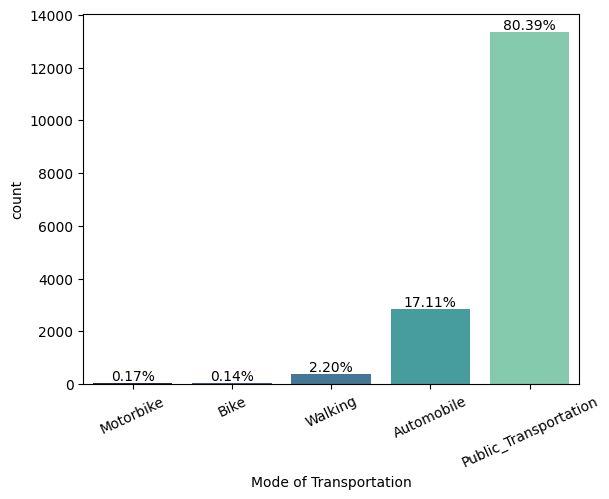

In [84]:
modes = train_df['MTRANS'].unique()[::-1]
ax =sns.countplot(x= train_df['MTRANS'], palette='mako',order=modes)

total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+ 0.006* total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Mode of Transportation')
plt.xticks(rotation = 25);

- **Public Transportation**: With 80.39% of individuals using public transportation, it's the most frequently used mode of transportation among the provided options.
- **Automobile**: The second most common mode of transportation is the automobile, with 17.11% of individuals using it.
- **Walking**: Walking is another mode of transportation, with only 2.2% of individuals choosing it.
- **Motorbike and Bike**: Both motorbikes and bikes have lower usage compared to public transportation, automobiles, and walking. Motorbikes are used by 0.17% individuals, while bikes are used by 0.14% of individuals.

In [85]:
mtrans_df = train_df.groupby('NObeyesdad')['MTRANS'].value_counts().to_frame()
mtrans_df['Percentage %'] = round(train_df.groupby('NObeyesdad')['MTRANS'].value_counts(normalize=True)*100, 2).values

In [86]:
mtrans_df

count  Percentage %
NObeyesdad          MTRANS                                    
Insufficient_Weight Public_Transportation   1737         86.08
                    Automobile               220         10.90
                    Walking                   55          2.73
                    Motorbike                  4          0.20
                    Bike                       2          0.10
Normal_Weight       Public_Transportation   2052         83.25
                    Automobile               253         10.26
                    Walking                  140          5.68
                    Motorbike                 11          0.45
                    Bike                       9          0.37
Obesity_Type_I      Public_Transportation   1697         72.90
                    Automobile               606         26.03
                    Walking                   21          0.90
                    Motorbike                  3          0.13
                    Bike                       1          0.04
Obesity_Type_II     Public_Transportation   1822         70.13
                    Automobile               767         29.52
                    Walking                    6          0.23
                    Motorbike                  3          0.12
Obesity_Type_III    Public_Transportation   3237        100.00
Overweight_Level_I  Public_Transportation   1475         75.95
                    Automobile               373         19.21
                    Walking                   83          4.27
                    Bike                       7          0.36
                    Motorbike                  4          0.21
Overweight_Level_II Public_Transportation   1329         65.86
                    Automobile               622         30.82
                    Walking                   60          2.97
                    Bike                       4          0.20
                    Motorbike                  3          0.15

* **Insufficient Weight**: The majority of individuals with insufficient weight seem to use public transportation (86.08%), followed by automobiles (10.9%). Only a few individuals use bikes, motorbikes, or walk as their mode of transportation.
*  **Normal Weight**: Similar to individuals with insufficient weight, those with normal weight also predominantly use public transportation (83.25%). However, there's a slightly higher usage of automobiles (10.26%) and walking (5.68%) compared to the insufficient weight category.

* **Overweight Level I and II**: For individuals classified under Overweight Level I and II, public transportation is the most common mode of transportation (75.95% and 65.86%, respectively), followed by automobiles. There's a smaller number of individuals who use walking, bikes, or motorbikes in these categories.

* **Obesity Type I and II**: Individuals classified under Obesity Type I and II primarily rely on public transportation (72.9% and 70.13% of individuals, respectively). There's also significant usage of automobiles, with slightly fewer individuals compared to public transportation. The numbers for bikes, motorbikes, and walking are relatively low for these categories.

* **Obesity Type III**: The majority of individuals classified under Obesity Type III use public transportation exclusively (100% of individuals).

### 2. Frequency of alcohol consumption (CALC)

In [87]:
round(train_df.groupby('NObeyesdad')['CALC'].value_counts(normalize=True).to_frame()*100,2)

proportion
NObeyesdad          CALC                  
Insufficient_Weight Sometimes        64.42
                    no               34.99
                    Frequently        0.59
Normal_Weight       Sometimes        62.84
                    no               34.73
                    Frequently        2.43
Obesity_Type_I      Sometimes        49.31
                    no               47.90
                    Frequently        2.79
Obesity_Type_II     Sometimes        85.84
                    no               13.82
                    Frequently        0.35
Obesity_Type_III    Sometimes       100.00
Overweight_Level_I  Sometimes        80.84
                    no               13.70
                    Frequently        5.46
Overweight_Level_II Sometimes        50.69
                    no               40.44
                    Frequently        8.87

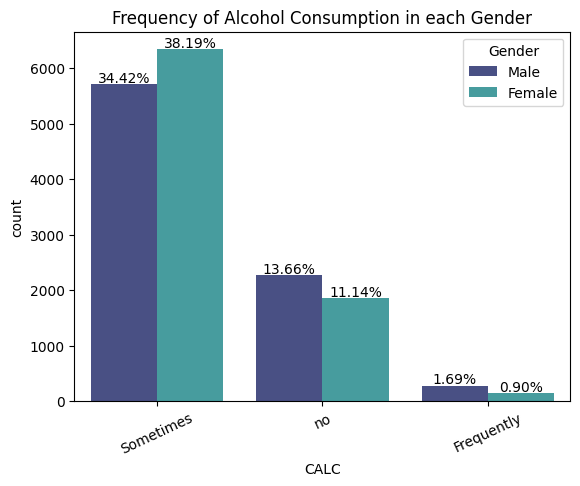

In [88]:
ax = sns.countplot(x='CALC', hue='Gender', data=train_df,palette='mako')
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.002 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('CALC')
plt.title('Frequency of Alcohol Consumption in each Gender')
plt.xticks(rotation=25)
plt.show()

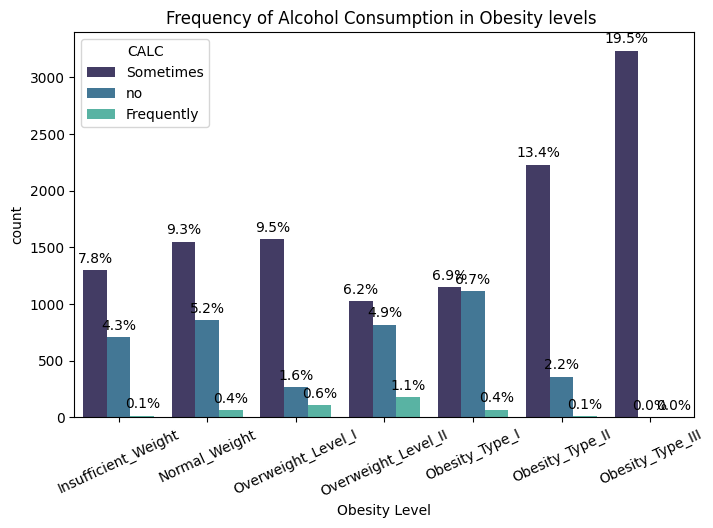

In [89]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='NObeyesdad', hue='CALC', data=train_df,palette='mako',order=target_order)
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.004 * total ,
            '{:2.1f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Obesity Level')
plt.title('Frequency of Alcohol Consumption in Obesity levels ')
plt.xticks(rotation=25)

plt.show()

* **Insufficient Weight**: Among individuals with insufficient weight, the majority (64.42%) report consuming alcohol sometimes. a smaller proportion (34.99%) reports not consuming alcohol at all, while a negligible percentage (0.55%) report consuming alcohol frequently.

* **Normal Weight**: Similar to the insufficient weight group, The majority (62.84%) of individuals with normal weight report consuming alcohol sometimes. A considerable proportion (34.73%) report not consuming alcohol, while a smaller percentage (2.43%) report consuming alcohol frequently.
 
* **Overweight Level I and II**: Among individuals classified under Overweight Level I, the majority (80.84%) report consuming alcohol sometimes, while a smaller percentage (13.70%) report not consuming alcohol. A notable fraction (5.46%) report consuming alcohol frequently. In contrast, among individuals classified under Overweight Level II, approximately half (50.69%) report consuming alcohol sometimes, while a considerable proportion (40.44%) report not consuming alcohol. A significant fraction (8.87%) report consuming alcohol frequently.
 
* **Obesity Type I**: Among individuals classified under Obesity Type I, nearly half (49.31%) report consuming alcohol sometimes, while a slightly lower percentage (47.90%) report not consuming alcohol. A small fraction (2.79%) report consuming alcohol frequently.

* **Obesity Type II**: In this category, a significant majority (85.84%) report consuming alcohol sometimes, while a smaller proportion (13.82%) report not consuming alcohol. A negligible percentage (0.35%) report consuming alcohol frequently.

* **Obesity Type III**: All individuals classified under Obesity Type III report consuming alcohol sometimes (100%). This suggests a consistent pattern of alcohol consumption among individuals in this category.
 


### 3. Monitoring of calorie consumption (SCC)

In [90]:
SCC_df = train_df.groupby('NObeyesdad')['SCC'].value_counts().to_frame()
SCC_df['Percentage %'] = round(train_df.groupby('NObeyesdad')['SCC'].value_counts(normalize=True)*100, 2).values

In [91]:
SCC_df

count  Percentage %
NObeyesdad          SCC                     
Insufficient_Weight no    1836         90.98
                    yes    182          9.02
Normal_Weight       no    2344         95.09
                    yes    121          4.91
Obesity_Type_I      no    2315         99.44
                    yes     13          0.56
Obesity_Type_II     no    2595         99.88
                    yes      3          0.12
Obesity_Type_III    no    3237        100.00
Overweight_Level_I  no    1741         89.65
                    yes    201         10.35
Overweight_Level_II no    2002         99.21
                    yes     16          0.79

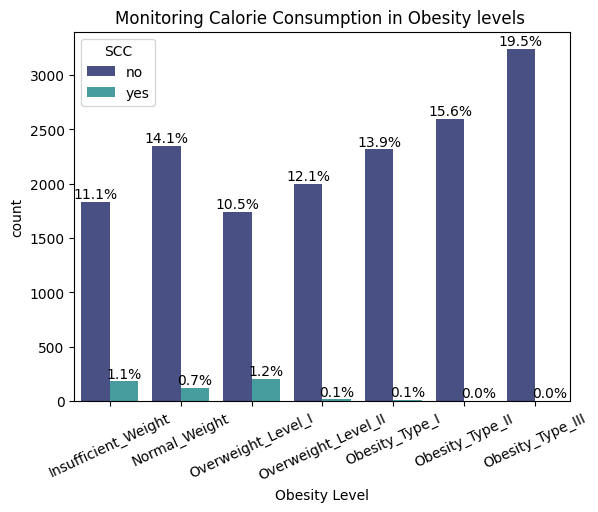

In [92]:
ax = sns.countplot(x='NObeyesdad', hue='SCC', data=train_df,palette='mako',order=target_order)
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.002 * total ,
            '{:.1f}%'.format((height/total)*100),

            ha="center") 
plt.xlabel('Obesity Level')
plt.xticks(rotation=25)
plt.title('Monitoring Calorie Consumption in Obesity levels ')
plt.savefig('SCC.png', transparent=True,bbox_inches='tight')
plt.show()

* **Insufficient Weight**: Among individuals with insufficient weight, the majority (90.98%) are not monitored for calorie consumption, while a smaller proportion (9.02%) are monitored.

* **Normal Weight**: Similarly, among individuals with normal weight, the majority (95.09%) are not monitored for calorie consumption, while a smaller percentage (4.91%) are monitored.

* **Overweight Level I and II**: Among individuals classified under Overweight Level I, the majority (89.65%) are not monitored for calorie consumption, while a smaller percentage (10.35%) are monitored. Similarly, among individuals classified under Overweight Level II, the majority (99.21%) are not monitored, with a small fraction (0.79%) being monitored.

* **Obesity Type I**: In this category, the vast majority (99.44%) of individuals are not monitored for calorie consumption, while only a small fraction (0.56%) are monitored.

* **Obesity Type II**: Among individuals classified under Obesity Type II, almost all (99.88%) are not monitored for calorie consumption, with only a tiny fraction (0.12%) being monitored.

* **Obesity Type III**: All individuals classified under Obesity Type III report not being monitored for calorie consumption (100.00%).

The analysis suggests that the practice of monitoring calorie consumption varies across different obesity levels. 
Individuals with higher obesity levels (such as Obesity Type III) are less likely to be monitored for calorie consumtion.


<Figure size 2200x800 with 0 Axes>

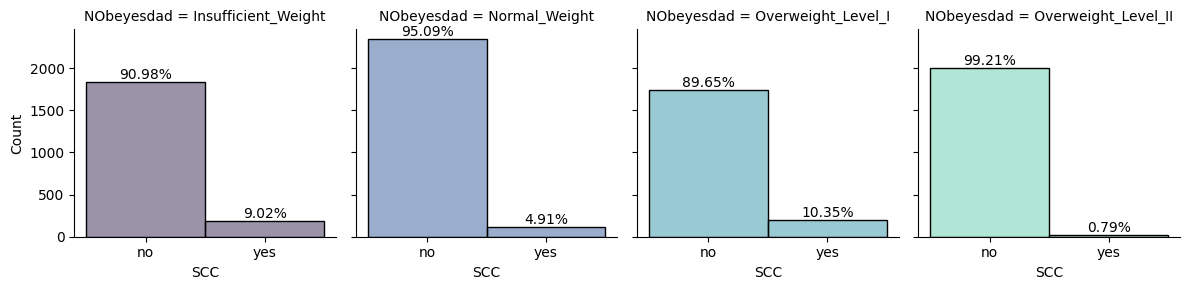

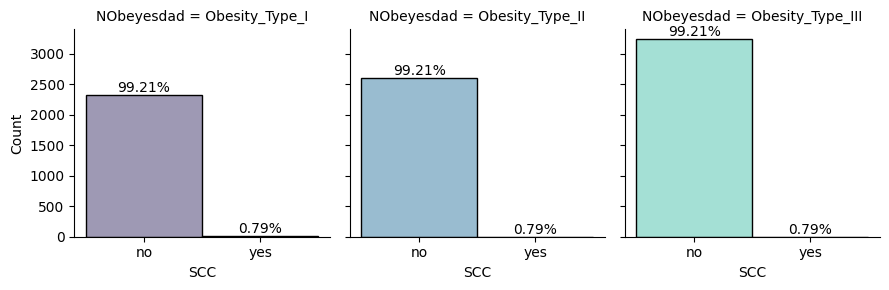

In [93]:
scc_df = train_df.groupby('NObeyesdad')['SCC'].value_counts(normalize=True).mul(100).round(2).reset_index(name='Percentage')

plt.figure(figsize=(22,8))
plot = sns.displot(x='SCC', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[:4], col_order=target_order[:4], legend=False)

for ax_idx, ax in enumerate(plot.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        scc = target_order[:4][ax_idx]
        scc_value = 'no' if bar_idx == 0 else 'yes'
        percentage = scc_df[(scc_df['NObeyesdad'] == scc) & (scc_df['SCC'] == scc_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
plt.savefig('scc3.png', transparent=True,bbox_inches='tight')

plot = sns.displot(x='SCC', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[4:], col_order=target_order[4:], legend=False)

for ax_idx, ax in enumerate(plot.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        favc = target_order[4:][ax_idx]
        scc_value = 'no' if bar_idx == 0 else 'yes'
        percentage = scc_df[(scc_df['NObeyesdad'] == scc) & (scc_df['SCC'] == scc_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
plt.savefig('scc4.png', transparent=True,bbox_inches='tight')
plt.tight_layout()
plt.show();

### 4 . SMOKE

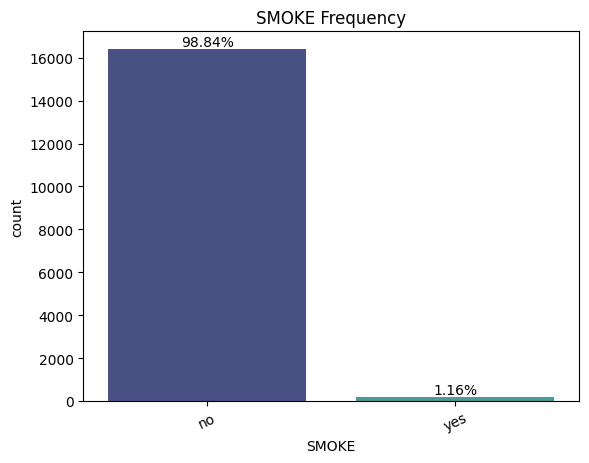

In [94]:
ax = sns.countplot(x= train_df['SMOKE'], palette='mako')
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.007 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('SMOKE')
plt.title('SMOKE Frequency')
plt.xticks(rotation=25)
plt.savefig('smoke1.png', transparent=True,bbox_inches='tight')
plt.show()

In [95]:
smoke_df = train_df.groupby('NObeyesdad')['SMOKE'].value_counts().to_frame()
smoke_df['Percentage %'] = round(train_df.groupby('NObeyesdad')['SMOKE'].value_counts(normalize=True)*100, 2).values
smoke_df

count  Percentage %
NObeyesdad          SMOKE                     
Insufficient_Weight no      2012         99.70
                    yes        6          0.30
Normal_Weight       no      2429         98.54
                    yes       36          1.46
Obesity_Type_I      no      2310         99.23
                    yes       18          0.77
Obesity_Type_II     no      2503         96.34
                    yes       95          3.66
Obesity_Type_III    no      3234         99.91
                    yes        3          0.09
Overweight_Level_I  no      1924         99.07
                    yes       18          0.93
Overweight_Level_II no      2002         99.21
                    yes       16          0.79

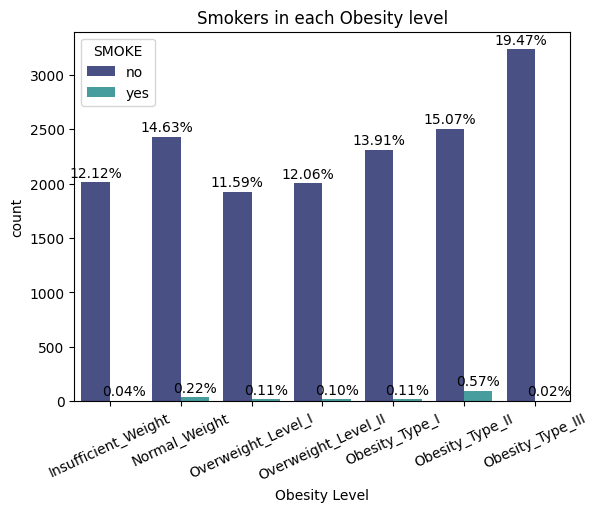

In [96]:
ax = sns.countplot(x='NObeyesdad', hue='SMOKE', data=train_df,palette='mako',order=target_order)
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.003 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 
plt.xlabel('Obesity Level')
plt.xticks(rotation=25)
plt.title('Smokers in each Obesity level')
plt.show()

In [97]:
train_df.reset_index(drop=True, inplace=True)

In [98]:
train_df.loc[np.where(train_df['SMOKE']=='yes')]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
39,Male,23.327836,1.763215,120.751656,yes,yes,2.219650,3.0,Sometimes,yes,1.833635,no,0.788659,0.000000,Sometimes,Public_Transportation,Obesity_Type_II
151,Female,21.000000,1.720000,72.000000,yes,yes,3.000000,3.0,Always,yes,1.000000,no,1.000000,1.000000,no,Public_Transportation,Normal_Weight
241,Male,24.000000,1.750000,112.000000,yes,no,1.000000,3.0,Sometimes,yes,2.000000,yes,1.000000,2.000000,no,Public_Transportation,Obesity_Type_II
553,Male,30.717727,1.913241,129.991623,yes,yes,2.111887,3.0,Sometimes,yes,1.290979,no,1.042680,0.000000,Sometimes,Public_Transportation,Obesity_Type_II
751,Male,31.315593,1.750150,118.382361,yes,yes,2.941929,3.0,Sometimes,yes,2.092326,no,0.868721,0.001716,Sometimes,Automobile,Obesity_Type_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15988,Female,25.000000,1.630000,62.000000,yes,no,3.000000,1.0,Frequently,yes,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
16020,Male,23.000000,1.750000,60.000000,no,no,2.000000,3.0,Sometimes,yes,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
16147,Male,30.684347,1.914186,129.874864,yes,yes,2.877743,3.0,Sometimes,yes,1.014876,no,0.982320,0.047473,Sometimes,Public_Transportation,Obesity_Type_II
16202,Male,27.000000,1.760000,112.000000,yes,yes,2.000000,3.0,Sometimes,yes,2.000000,no,0.000000,1.000000,no,Automobile,Obesity_Type_II


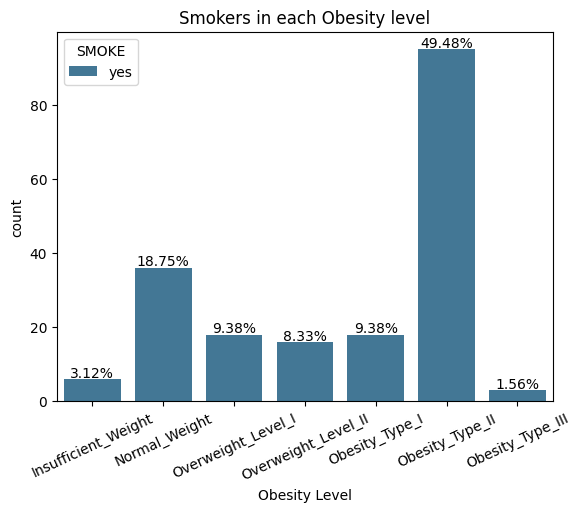

In [99]:
ax = sns.countplot(x='NObeyesdad', hue='SMOKE', data=train_df.loc[np.where(train_df['SMOKE']=='yes')],palette='mako',order=target_order)
total = float(len(train_df.loc[np.where(train_df['SMOKE']=='yes')]))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.003 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Obesity Level')
plt.xticks(rotation=25)
plt.title('Smokers in each Obesity level')
plt.savefig('smoke2.png', transparent=True,bbox_inches='tight')
plt.show()

In [100]:
no_of_smokers = len(train_df.loc[np.where(train_df['SMOKE']=='yes')])
no_of_smokers_obese_II = len(train_df.loc[np.where((train_df['SMOKE']=='yes') & (train_df['NObeyesdad']=='Obesity_Type_II'))])

In [101]:
print(f'{round((no_of_smokers_obese_II/no_of_smokers)*100,2)} % of smokers are type II obese')

49.48 % of smokers are type II obese


* **Insufficient Weight**: 
Among individuals with insufficient weight, the majority (99.70%) do not smoke, while a very small percentage (0.3%) do smoke.

* **Normal Weight**: 
Also, mong individuals with normal weight, the vast majority (98.54%) do not smoke, while a small percentage (1.46%) do smoke.

* **Overweight Level I and II**: 
Among individuals classified under Overweight Level I, the majority (99.07%) do not smoke, while a small percentage (0.93%) do smoke. Similarly, among individuals classified under Overweight Level II, the majority (99.21%) do not smoke, with a slightly smaller percentage (0.79%) reporting smoking.

* **Obesity Type I**: 
In this category, the majority (99.23%) of individuals do not smoke, while a small fraction (0.87%) do smoke.

* **Obesity Type II**: 
Among individuals classified under Obesity Type II, a significant majority (96.34%) do not smoke, while a notable percentage **(3.66%)** do smoke, which relatively large percentage of individuals with respect to other categories.

* **Obesity Type III**: 
All individuals classified under Obesity Type III report not smoking (99.91%), with only a negligible fraction (0.9%) reporting smoking.

- **Obesity Type II category has the most smokers (49.48%).**

### 5. Frequent consumption of high caloric food items (FAVC)

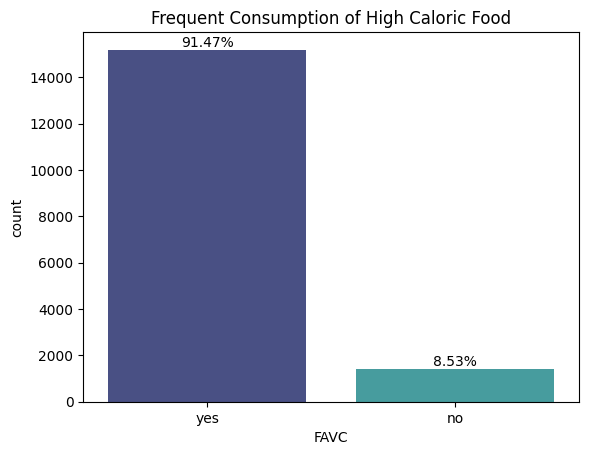

In [102]:
ax = sns.countplot(x= train_df['FAVC'], palette='mako')
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.007 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('FAVC')
plt.title('Frequent Consumption of High Caloric Food')
plt.savefig('Favc1.png', transparent=True,bbox_inches='tight')
plt.show()

In [103]:
favc_df = train_df.groupby('NObeyesdad')['FAVC'].value_counts().to_frame()
favc_df['Percentage %'] = round(train_df.groupby('NObeyesdad')['FAVC'].value_counts(normalize=True)*100, 2).values
favc_df

count  Percentage %
NObeyesdad          FAVC                     
Insufficient_Weight yes    1726         85.53
                    no      292         14.47
Normal_Weight       yes    2064         83.73
                    no      401         16.27
Obesity_Type_I      yes    2255         96.86
                    no       73          3.14
Obesity_Type_II     yes    2560         98.54
                    no       38          1.46
Obesity_Type_III    yes    3236         99.97
                    no        1          0.03
Overweight_Level_I  yes    1760         90.63
                    no      182          9.37
Overweight_Level_II yes    1589         78.74
                    no      429         21.26

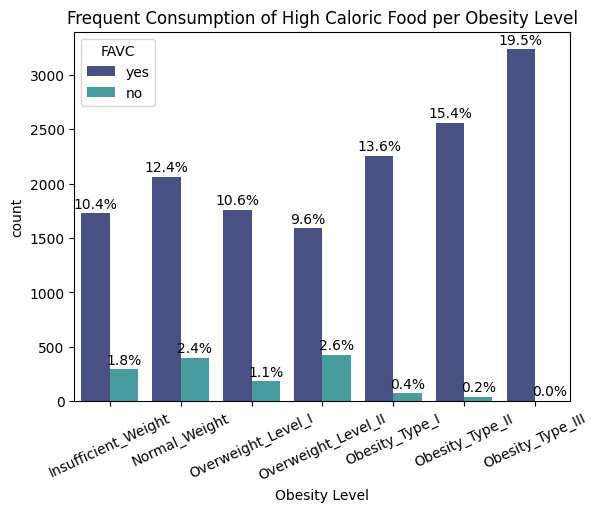

In [104]:
ax = sns.countplot(x='NObeyesdad', hue='FAVC', data=train_df,palette='mako',order=target_order)
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.003* total ,
            '{:.1f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Obesity Level')
plt.xticks(rotation=25)
plt.title('Frequent Consumption of High Caloric Food per Obesity Level')
plt.savefig('Favc2.png', transparent=True,bbox_inches='tight')
plt.show()

<Figure size 2200x800 with 0 Axes>

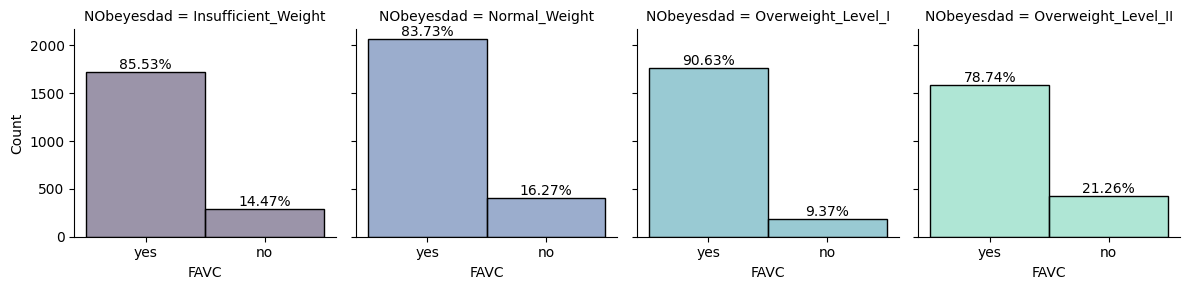

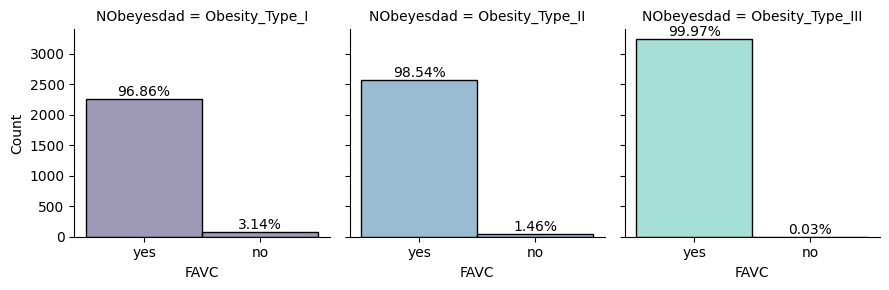

In [105]:
favc_df = train_df.groupby('NObeyesdad')['FAVC'].value_counts(normalize=True).mul(100).round(2).reset_index(name='Percentage')

plt.figure(figsize=(22,8))
plot = sns.displot(x='FAVC', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[:4], col_order=target_order[:4], legend=False)

for ax_idx, ax in enumerate(plot.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        favc = target_order[:4][ax_idx]
        favc_value = 'yes' if bar_idx == 0 else 'no'
        percentage = favc_df[(favc_df['NObeyesdad'] == favc) & (favc_df['FAVC'] == favc_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
plt.savefig('Favc3.png', transparent=True,bbox_inches='tight')
plot = sns.displot(x='FAVC', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[4:], col_order=target_order[4:], legend=False)

for ax_idx, ax in enumerate(plot.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        favc = target_order[4:][ax_idx]
        favc_value = 'yes' if bar_idx == 0 else 'no'
        percentage = favc_df[(favc_df['NObeyesdad'] == favc) & (favc_df['FAVC'] == favc_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
plt.savefig('Favc4.png', transparent=True,bbox_inches='tight')
plt.tight_layout()
plt.show()

- **Insufficient Weight**:

Approximately 85.53% of individuals in this group consume high caloric food, while about 14.47% do not.

- **Normal Weight:**

Around 83.73% of individuals in this group consume high caloric food, while about 16.27% do not.

- **Overweight Level I:**

Around 90.86% of individuals in this group consume high caloric food, while about 9.37% do not.

- **Overweight Level II:**

While still high, the percentage of individuals consuming high caloric food is relatively lower in this group compared to others, at approximately 78.74%. About 21.3% do not consume it.

There is a relatively higher proportion of individuals in this group who do not consume high caloric food compared to other groups, although the majority still consume it.
- **Obesity Type I:**

A significantly high percentage (approximately 96.86%) of individuals in this group consume high caloric food, with only 3.14% not consuming it.

- **Obesity Type II:**

Similarly, a vast majority (around 98.54%) of individuals in this group consume high caloric food, while only 1.46% do not.
The prevalence of high caloric food consumption is very high in this group.

- **Obesity Type III:**

We can say that all individuals (99.97%) in this group consume high caloric food, with only a negligible percentage (0.03%) not consuming it.

Similarily, The prevalence of high caloric food consumption is extremely high in this group.



### 6. Frequency of Consuming food between the Meals (CAEC)

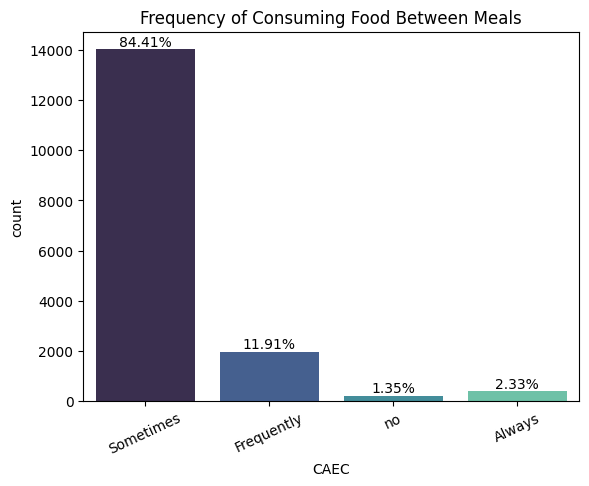

In [106]:
ax = sns.countplot(x= train_df['CAEC'], palette='mako')
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.007 * total ,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('CAEC')
plt.xticks(rotation=25)
plt.title('Frequency of Consuming Food Between Meals')
plt.savefig('caec1.png', transparent=True,bbox_inches='tight')
plt.show()

In [107]:
caec_df = train_df.groupby('NObeyesdad')['CAEC'].value_counts().to_frame()
caec_df['Percentage %'] = round(train_df.groupby('NObeyesdad')['CAEC'].value_counts(normalize=True)*100, 2).values
caec_df

count  Percentage %
NObeyesdad          CAEC                           
Insufficient_Weight Sometimes    1017         50.40
                    Frequently    967         47.92
                    Always         29          1.44
                    no              5          0.25
Normal_Weight       Sometimes    1637         66.41
                    Frequently    565         22.92
                    Always        230          9.33
                    no             33          1.34
Obesity_Type_I      Sometimes    2225         95.58
                    Always         50          2.15
                    Frequently     46          1.98
                    no              7          0.30
Obesity_Type_II     Sometimes    2581         99.35
                    Frequently      9          0.35
                    Always          7          0.27
                    no              1          0.04
Obesity_Type_III    Sometimes    3233         99.88
                    Frequently      3          0.09
                    Always          1          0.03
Overweight_Level_I  Sometimes    1500         77.24
                    Frequently    222         11.43
                    no            172          8.86
                    Always         48          2.47
Overweight_Level_II Sometimes    1824         90.39
                    Frequently    166          8.23
                    Always         22          1.09
                    no              6          0.30

In [108]:
caec_order = train_df['CAEC'].value_counts().index.tolist()
print(caec_order)

['Sometimes', 'Frequently', 'Always', 'no']


<Figure size 2200x800 with 0 Axes>

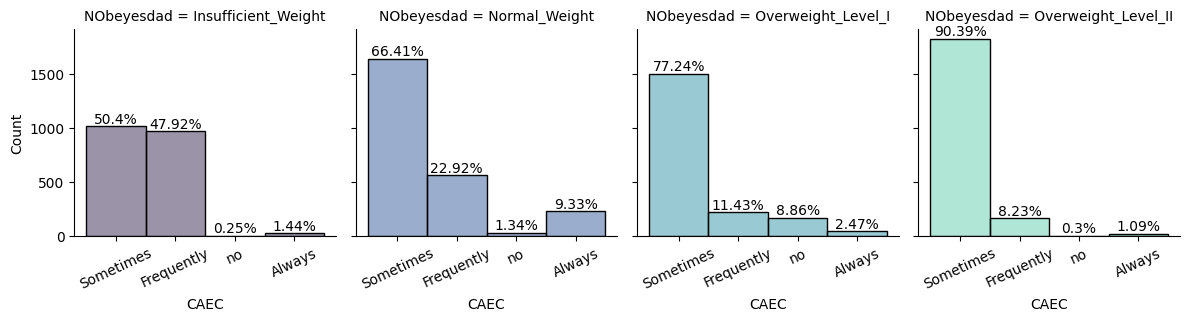

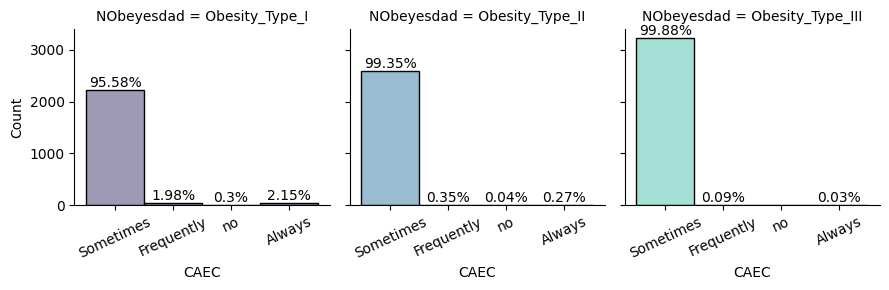

In [110]:
caec_df = train_df.groupby('NObeyesdad')['CAEC'].value_counts(normalize=True).mul(100).round(2).reset_index(name='Percentage')

plt.figure(figsize=(22, 8))


plot1 = sns.displot(x='CAEC', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[:4], col_order=target_order[:4], legend=False)

for ax_idx, ax in enumerate(plot1.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        ceac = target_order[:4][ax_idx]
        ceac_value = ['Sometimes', 'Frequently','no','Always'][bar_idx]
        percentage = caec_df[(caec_df['NObeyesdad'] == ceac) & (caec_df['CAEC'] == ceac_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, fontsize=10)
            
plt.savefig('ceac3.png', transparent=True, bbox_inches='tight')

plot2 = sns.displot(x='CAEC', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[4:], col_order=target_order[4:], legend=False)

for ax_idx, ax in enumerate(plot2.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        ceac = target_order[4:][ax_idx]
        ceac_value = ['Sometimes', 'Frequently','no','Always'][bar_idx]
        percentage = caec_df[(caec_df['NObeyesdad'] == ceac) & (caec_df['CAEC'] == ceac_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, fontsize=10)
plt.tight_layout()
plt.savefig('ceac4.png', transparent=True, bbox_inches='tight')
plt.show()


**Obesity Type I:**

- Majority of individuals (95.58%) consume food between meals "Sometimes," indicating a prevalent but occasional snacking behavior.
- A small portion consumes food "Always" (2.15%) or "Frequently" (1.98%), suggesting some individuals have more frequent snacking habits.
- Very few individuals (0.30%) reported consuming no food between meals, indicating rare instances of skipping snacks.

**Obesity Type II:**

- Nearly all individuals (99.35%) consume food between meals "Sometimes," showing a consistent pattern of snacking.
- A negligible percentage consumes food "Frequently" (0.35%), indicating rare instances of frequent snacking.
- Very few individuals (0.27%) reported consuming food "Always" or "No" (0.04%) between meals, suggesting minimal occurrences of extreme snacking behavior or skipping snacks.

**Obesity Type III:**

- Nearly all individuals (99.88%) consume food between meals "Sometimes," suggesting a universal pattern of occasional snacking.
- A very small percentage consumes food "Always" (0.03%) or "Frequently" (0.09%), indicating rare instances of frequent or constant snacking.
- No individuals reported consuming no food between meals, indicating no instances of skipping snacks.

### 7. Gender

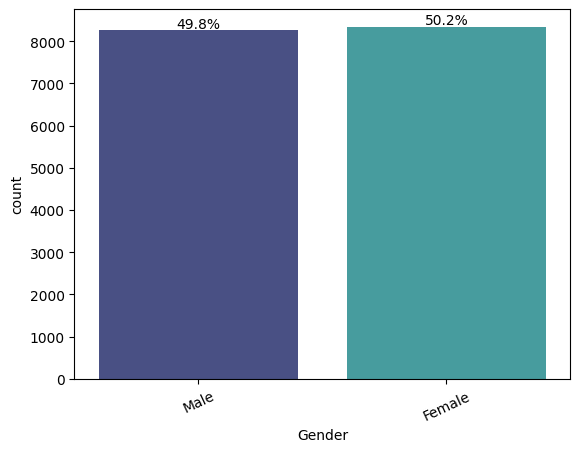

In [111]:
ax = sns.countplot(x= train_df['Gender'], palette='mako')
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.003* total ,
            '{:.1f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Gender')
plt.xticks(rotation=25)
plt.savefig('gender1.png', transparent=True,bbox_inches='tight')
plt.show()

In [112]:
gender_df = train_df.groupby('NObeyesdad')['Gender'].value_counts().to_frame()
gender_df['Percentage %'] = round(train_df.groupby('NObeyesdad')['Gender'].value_counts(normalize=True)*100, 2).values
gender_df

count  Percentage %
NObeyesdad          Gender                     
Insufficient_Weight Female   1290         63.92
                    Male      728         36.08
Normal_Weight       Female   1344         54.52
                    Male     1121         45.48
Obesity_Type_I      Male     1326         56.96
                    Female   1002         43.04
Obesity_Type_II     Male     2592         99.77
                    Female      6          0.23
Obesity_Type_III    Female   3233         99.88
                    Male        4          0.12
Overweight_Level_I  Male     1099         56.59
                    Female    843         43.41
Overweight_Level_II Male     1394         69.08
                    Female    624         30.92

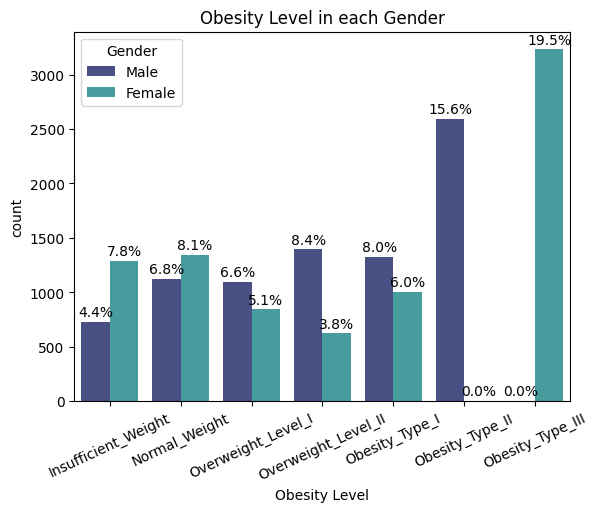

In [113]:
ax = sns.countplot(x='NObeyesdad', hue='Gender', data=train_df,palette='mako',order=target_order)
total = float(len(train_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height+0.003* total ,
            '{:.1f}%'.format((height/total)*100),
            ha="center") 

plt.xlabel('Obesity Level')
plt.xticks(rotation=25)
plt.title('Obesity Level in each Gender')
plt.savefig('gender2.png', transparent=True,bbox_inches='tight')
plt.show()

The data shows that there are variations in the distribution of obesity types between genders:

**Insufficient weight** cases show a higher percentage among females compared to males, with 63.92% of cases being female.

**Normal weight distribution** appears to be slightly higher among females, with 54.52% of cases being female.
Prevalence of Overweight Levels:

**Overweight Level II** appears to be more common among males, with 69.08% of cases being male.
**Overweight Level I** while still more prevalent among males, has a closer distribution between genders compared to Overweight Level II.

- **Obesity Type II** seems to be more prevalent among males, with 99.77% of cases being male.
- **Obesity Type III** also shows a significant gender skew, with 99.88% of cases being female.

**Overall Gender Trends:**

There seems to be a gender variations in certain types of obesity and overweight levels. For example, **Obesity Type II and Overweight Level II** are more prevalent among **males**, while **Obesity Type III** shows a significant dominance among **females** that could be due to several reasons such as:

***Biological Differences:*** Hormonal fluctuations and differences in fat distribution between males and females may contribute. Females tend to have higher levels of estrogen, which can influence fat deposition, particularly around the hips and thighs.

***Pregnancy and Childbirth:*** Pregnancy-related weight gain and challenges in losing postpartum weight could contribute to the higher prevalence of Obesity Type III among females. Additionally, the physiological changes during pregnancy, such as increased appetite and decreased physical activity, can contribute to weight gain.

<Figure size 2200x800 with 0 Axes>

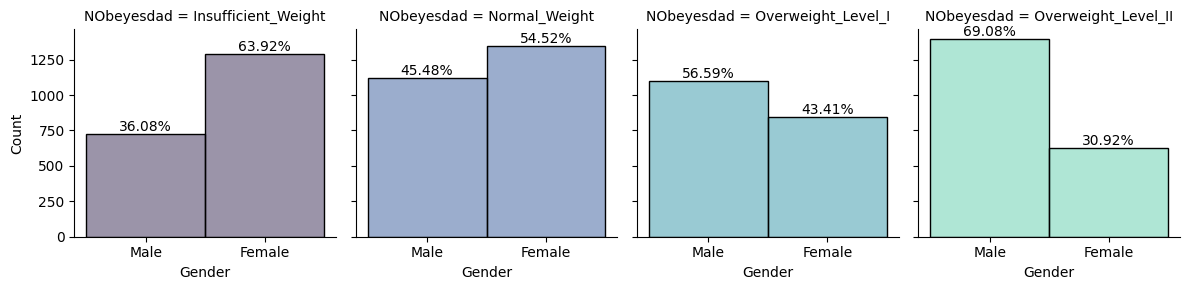

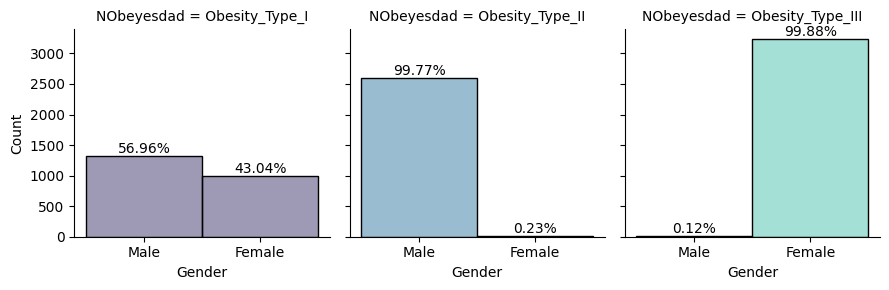

In [407]:
gender_df = train_df.groupby('NObeyesdad')['Gender'].value_counts(normalize=True).mul(100).round(2).reset_index(name='Percentage')

plt.figure(figsize=(22,8))
plot = sns.displot(x='Gender', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[:4], col_order=target_order[:4], legend=False)

for ax_idx, ax in enumerate(plot.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        gender = target_order[:4][ax_idx]
        gender_value = 'Male' if bar_idx == 0 else 'Female'
        percentage = gender_df[(gender_df['NObeyesdad'] == gender) & (gender_df['Gender'] == gender_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
plt.savefig('gender3.png', transparent=True,bbox_inches='tight')

plot = sns.displot(x='Gender', hue='NObeyesdad', col='NObeyesdad', height=3, data=train_df, palette='mako', hue_order=target_order[4:], col_order=target_order[4:], legend=False)

for ax_idx, ax in enumerate(plot.axes.flat):
    for bar_idx, p in enumerate(ax.patches):
        gender = target_order[4:][ax_idx]
        gender_value = 'Male' if bar_idx == 0 else 'Female'
        percentage = gender_df[(gender_df['NObeyesdad'] == gender) & (gender_df['Gender'] == gender_value)]['Percentage'].values
        if len(percentage) > 0:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{percentage[0]}%', (x, y), ha='center', va='bottom')
plt.savefig('gender4.png', transparent=True,bbox_inches='tight')

## Numerical Features Analysis

### 1. AGE

In [408]:
train_df.groupby('NObeyesdad').describe()['Age'].transpose()

NObeyesdad,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2018.000000,2465.000000,2328.000000,2598.000000,3237.000000,1942.000000,2018.000000
mean,19.350657,20.836222,25.026141,27.710789,24.106708,23.020833,26.005754
std,2.236471,3.477746,7.210969,4.238375,2.584546,5.892234,7.731930
min,16.000000,14.000000,16.000000,17.000000,18.000000,15.000000,16.834813
25%,18.000000,18.000000,21.000000,24.443011,21.556361,19.637947,20.984441
50%,19.000000,21.000000,22.851773,26.701514,25.957740,21.000000,23.000000
75%,20.345161,22.000000,26.000000,30.628650,26.000000,23.000000,32.999280
max,43.238402,51.000000,55.000000,53.783977,26.699317,55.022494,56.000000


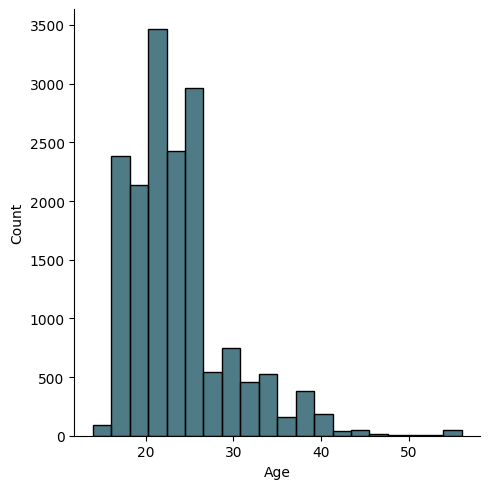

In [409]:
sns.displot(x= 'Age',data=train_df, color = '#134f5c', bins =20)
plt.savefig('age.png', transparent=True,bbox_inches='tight')

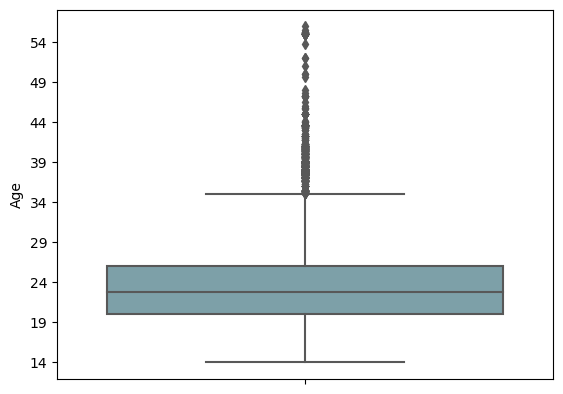

In [410]:
sns.boxplot(y= 'Age',data=train_df, color ='#76a5af')
plt.yticks(np.arange(train_df['Age'].min(), train_df['Age'].max(),step=5))
plt.savefig('age1.png', transparent=True,bbox_inches='tight')

- The individuals fall within the age range of 14 to 56, with the majority clustered between 20 and 27. 
- However, there are outliers beyond 35 years of age.

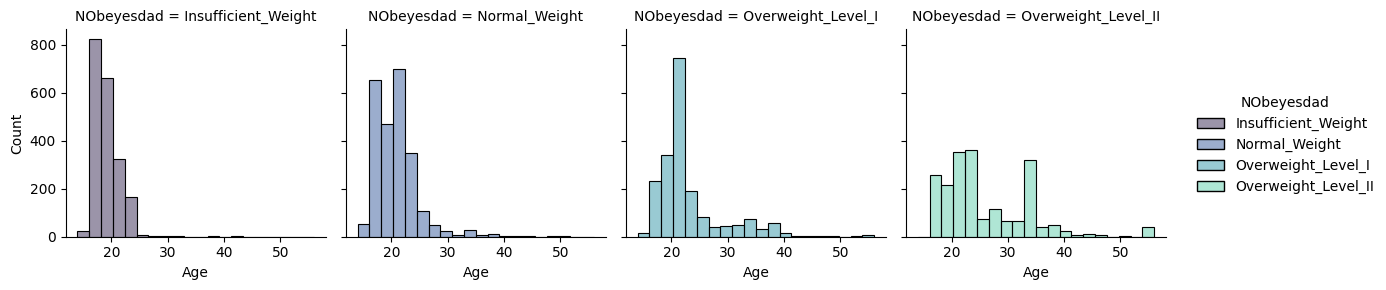

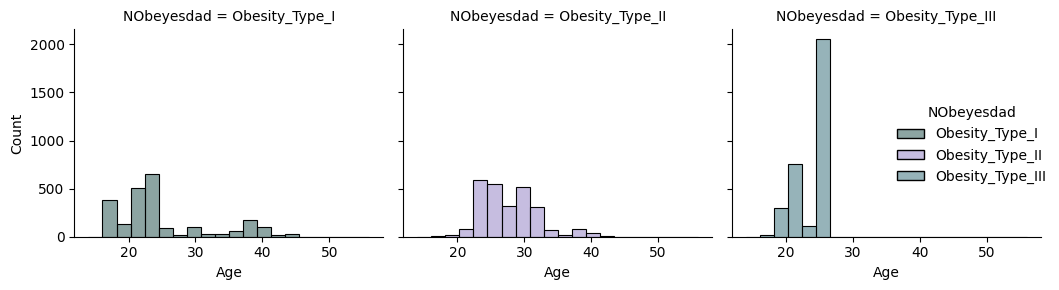

In [411]:
custom_colors = ['#1a4b46','#8e7cc3','#2e6975']
custom_palette = sns.color_palette(custom_colors)
sns.displot(x= 'Age',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette="mako",hue_order=target_order[:4],col_order=target_order[:4],bins=20)
plt.savefig('age2.png', transparent=True,bbox_inches='tight')
sns.displot(x= 'Age',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette=custom_palette,hue_order=target_order[4:],col_order=target_order[4:],bins=20)
plt.savefig('age3.png', transparent=True,bbox_inches='tight')
plt.tight_layout()

- About 2000 individuals who are 26 years old suffer from obesity type III.
- obesity type III is common between young people from 16 to 26 years old.

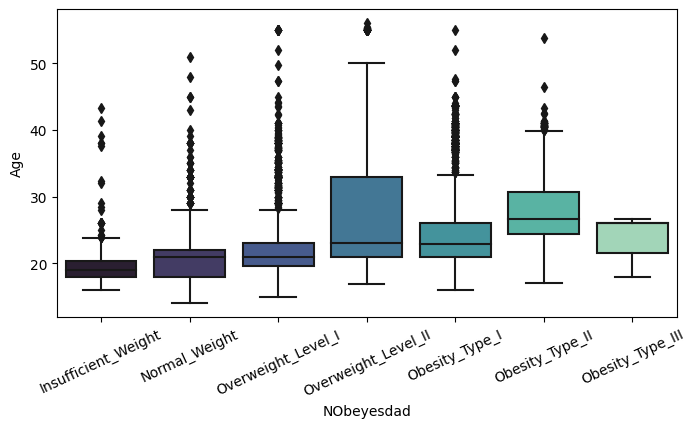

In [412]:
plt.figure(figsize=(8,4))
sns.boxplot(x='NObeyesdad', y='Age', data=train_df, palette='mako',order=target_order)
plt.xticks(rotation=25);
plt.savefig('age4.png', transparent=True,bbox_inches='tight')

- In Overweight_Level_II the data is right skewed (majority of the indviduals in this category are youth).
- Individuals classified as 'Obesity_Type_II' have the highest mean age (27 years), followed by 'Obesity_Type_I' (25 years) and 'Obesity_Type_III' (24.12 years). This suggests that older individuals are more likely to be classified into these obesity levels.

### 2. WEIGHT

In [413]:
train_df.groupby('NObeyesdad').describe()['Weight'].transpose()

NObeyesdad,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2018.000000,2465.000000,2328.000000,2598.000000,3237.000000,1942.000000,2018.000000
mean,49.834820,61.401921,92.403104,115.972040,117.777985,74.212147,81.945839
std,5.853672,8.520423,11.350126,7.816739,13.329926,8.087005,7.405624
min,39.101805,41.890204,40.202773,76.202761,42.000000,42.000000,55.000000
25%,45.000000,55.000000,82.000000,112.725005,109.959714,68.850970,79.000000
50%,50.000000,60.000000,90.032671,118.332966,111.914361,75.000000,81.022119
75%,52.320836,68.000000,104.721571,120.915175,132.579270,80.000000,85.000000
max,113.714521,90.000000,152.567671,130.986338,165.057269,96.679131,115.000000


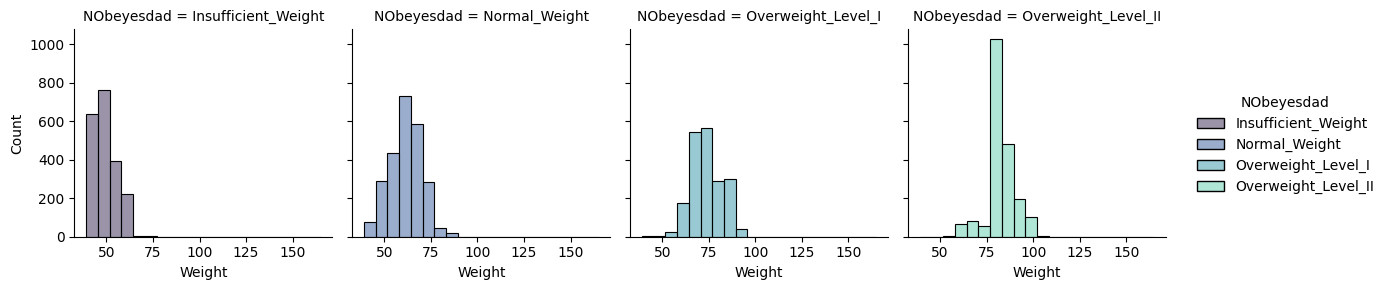

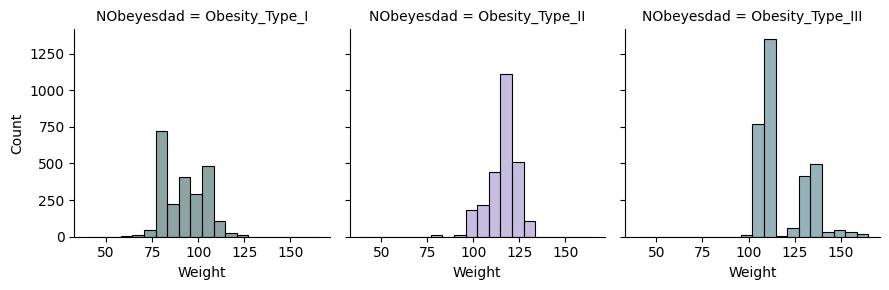

In [414]:
custom_colors = ['#1a4b46','#8e7cc3','#2e6975']
custom_palette = sns.color_palette(custom_colors)
sns.displot(x= 'Weight',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette="mako",hue_order=target_order[:4],col_order=target_order[:4],bins=20)
plt.savefig('weight.png', transparent=True,bbox_inches='tight')
sns.displot(x= 'Weight',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette=custom_palette,hue_order=target_order[4:],col_order=target_order[4:],bins=20,legend = False)
plt.savefig('weight1.png', transparent=True)
plt.tight_layout()

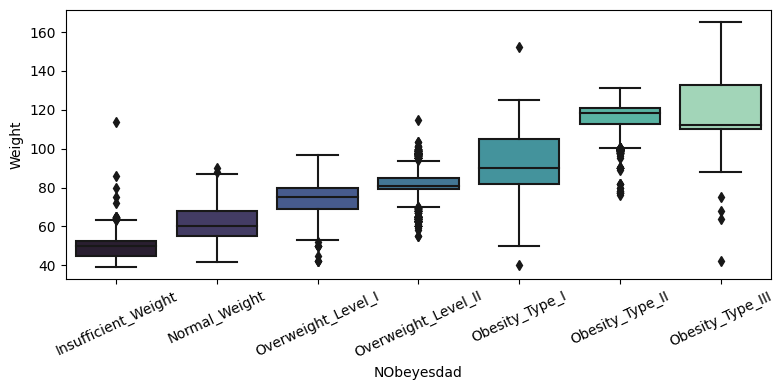

In [415]:
plt.figure(figsize=(8,4))
sns.boxplot(x='NObeyesdad', y='Weight', data=train_df, palette='mako',order=target_order)
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('weight2.png', transparent=True)

- As excpected, individuals classified as obese (Obesity_Type_I, Obesity_Type_II, Obesity_Type_III) generally tend to have higher weights compared to those classified as normal Weight or overweight.

### 3. Number of main meals consumed per day (NCP)

In [416]:
train_df.groupby('NObeyesdad').describe()['NCP'].transpose()

NObeyesdad,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2018.000000,2465.000000,2328.000000,2598.000000,3237.000000,1942.000000,2018.000000
mean,2.895932,2.889671,2.462329,2.798159,2.999937,2.521334,2.580618
std,0.877667,0.671159,0.826208,0.489768,0.003409,0.929056,0.753644
min,1.000000,1.000000,1.000000,1.000000,2.806298,1.000000,1.000000
25%,3.000000,3.000000,1.816980,2.959026,3.000000,1.477581,2.395785
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.207071,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000


In [417]:
train_df['NCP'] = round(train_df['NCP'])
X_train['NCP'] = round(X_train['NCP'])
X_test['NCP'] = round(X_test['NCP'])

In [418]:
train_df.groupby('NObeyesdad').describe()['NCP'].transpose()

NObeyesdad,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2018.000000,2465.000000,2328.000000,2598.000000,3237.0,1942.000000,2018.000000
mean,2.893954,2.889655,2.458333,2.807929,3.0,2.527806,2.592666
std,0.897113,0.671179,0.848153,0.529149,0.0,0.950609,0.775547
min,1.000000,1.000000,1.000000,1.000000,3.0,1.000000,1.000000
25%,3.000000,3.000000,2.000000,3.000000,3.0,1.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000
75%,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000
max,4.000000,4.000000,4.000000,4.000000,3.0,4.000000,4.000000


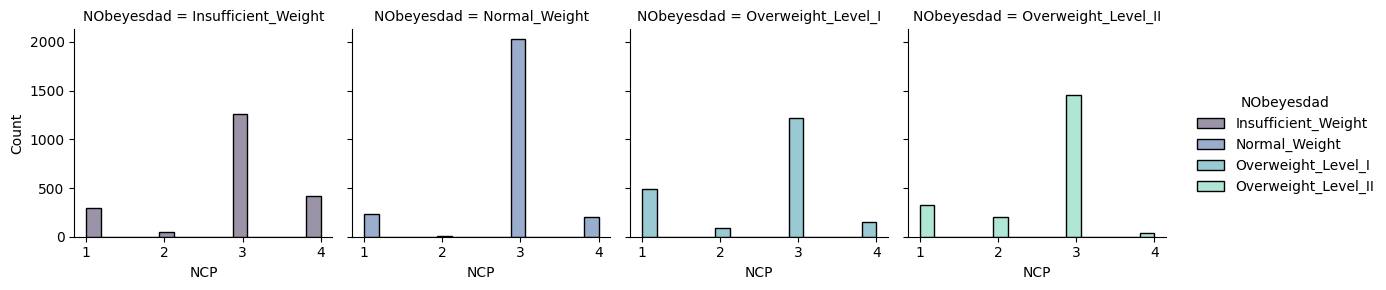

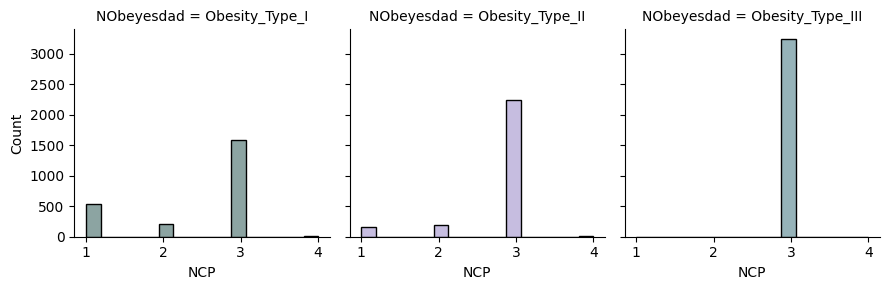

In [419]:
sns.displot(x= 'NCP',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette="mako",hue_order=target_order[:4],col_order=target_order[:4])
plt.savefig('ncp.png', transparent=True,bbox_inches='tight')
sns.displot(x= 'NCP',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette=custom_palette,hue_order=target_order[4:],col_order=target_order[4:],legend = False)
plt.savefig('ncp1.png', transparent=True)
plt.tight_layout()

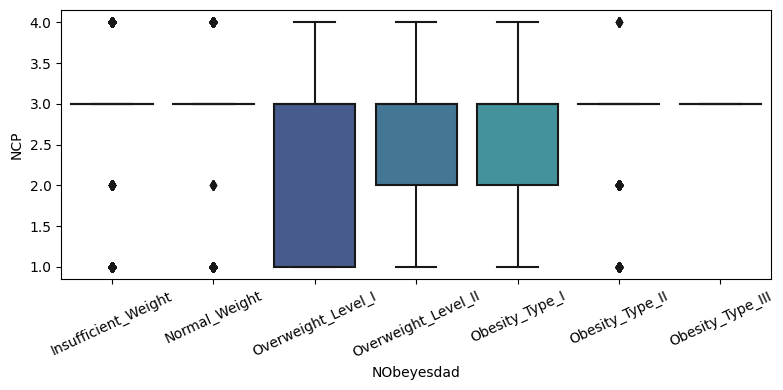

In [420]:
plt.figure(figsize=(8,4))
sns.boxplot(x='NObeyesdad', y='NCP', data=train_df, palette='mako',order=target_order)
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('ncp2.png', transparent=True)

- Across all weight classifications, the median NCP is 3, suggesting that a significant portion of individuals consume three meals daily regardless of weight status.
- There are some outliers in certain weight classifications, which could indicate extreme eating habits or variations within the population.

- Insufficient Weight:

Average: 2.89 main meals/day.
Majority consume around 3 meals/day.
Range: 1 to 4 meals/day.

- Normal Weight:

Average: 2.89 main meals/day.
Majority consume around 3 meals/day.
Range: 1 to 4 meals/day.

- Overweight Level I:

Average: 2.53 main meals/day.
Majority consume around 3 meals/day with some variability.
Range: 1 to 4 meals/day.

- Overweight Level II:

Average: 2.58 main meals/day.
Majority consume around 3 meals/day with slightly higher mean.
Range: 1 to 4 meals/day.

- Obesity Type I:

Average: 2.46 main meals/day.
Most individuals consume around 3 meals/day with some variability.
Range: 1 to 4 meals/day.

- Obesity Type II:

Average: 2.80 main meals/day.
Most individuals consume around 3 meals/day with slightly higher mean.
Range: 1 to 4 meals/day.

- Obesity Type III:

Average: 3.00 main meals/day.
Consistent average of 3 meals/day with little variability.
Range: 3 meals/day.

### 4. Amount of consumed water daily (CH2O)

In [421]:
train_df.groupby('NObeyesdad').describe()['CH2O'].transpose()

NObeyesdad,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2018.000000,2465.000000,2328.000000,2598.000000,3237.000000,1942.000000,2018.000000
mean,1.733017,1.810029,2.128109,1.985841,2.335673,2.072974,2.004044
std,0.563346,0.557039,0.631564,0.547819,0.573772,0.620821,0.532038
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.964233,1.828290,1.859089,1.993078,1.979837
50%,2.000000,2.000000,2.000000,2.016296,2.618198,2.000000,2.000000
75%,2.000000,2.000000,2.715572,2.203551,2.735706,2.566629,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


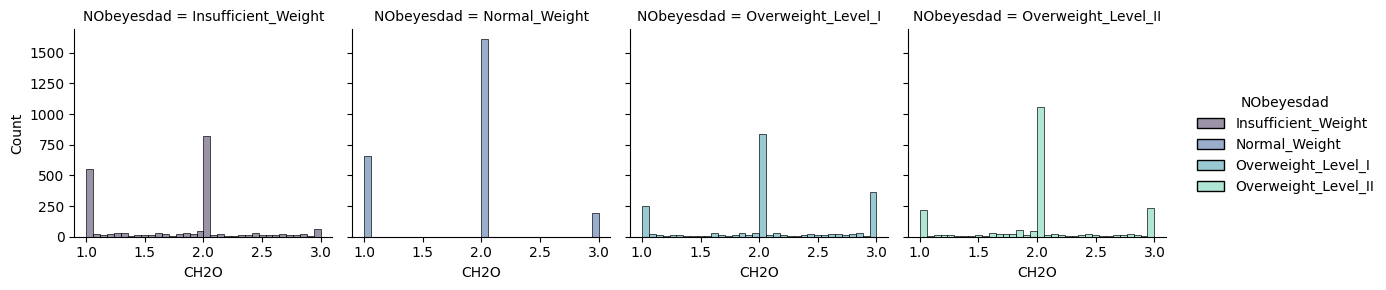

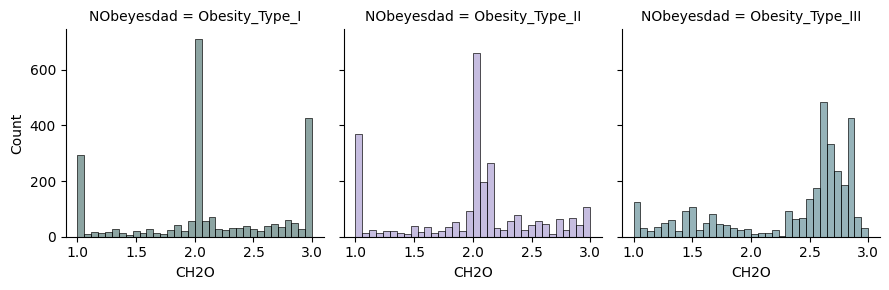

In [422]:
sns.displot(x= 'CH2O',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette="mako",hue_order=target_order[:4],col_order=target_order[:4])
plt.savefig('h2o.png', transparent=True,bbox_inches='tight')
sns.displot(x= 'CH2O',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette=custom_palette,hue_order=target_order[4:],col_order=target_order[4:],legend = False)
plt.savefig('h2o.png', transparent=True)
plt.tight_layout()

- There are slight differences in the average daily water consumption across different obesity levels, with moderate variability observed within each group. Most individuals across all obesity levels have a daily water consumption between 1 and 3 liters.

### 5. Frequency of engaging in physical activity (FAF)

In [423]:
train_df.groupby('NObeyesdad').describe()['FAF'].transpose()

NObeyesdad,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2018.000000,2465.00000,2328.000000,2598.000000,3237.000000,1942.000000,2018.000000
mean,1.177069,1.17714,0.922488,1.025996,0.556784,1.125681,1.053849
std,0.842295,0.90447,0.923836,0.543433,0.733389,0.867590,0.828917
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.310235,1.00000,0.000000,0.744577,0.000000,0.523847,0.390007
50%,1.000000,1.00000,1.000000,1.000000,0.035928,1.000000,1.000000
75%,2.000000,2.00000,1.319267,1.333435,1.444382,1.999773,1.593101
max,3.000000,3.00000,3.000000,3.000000,2.892922,3.000000,3.000000


- The scale used to measure physical activity frequency ranges from 0 to 3, with 0 representing no engagement in physical activity and 3 representing high engagement (e.g., days per week).

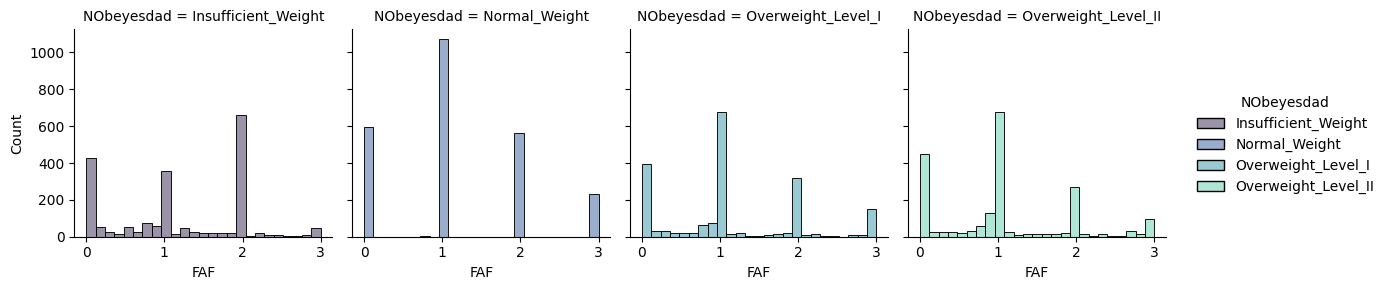

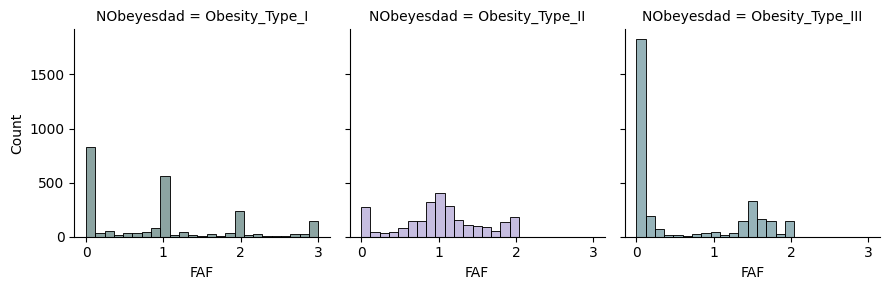

In [424]:
sns.displot(x= 'FAF',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette="mako",hue_order=target_order[:4],col_order=target_order[:4])
plt.savefig('faf.png', transparent=True,bbox_inches='tight')
sns.displot(x= 'FAF',hue= 'NObeyesdad',col= 'NObeyesdad',height=3,data=train_df, palette=custom_palette,hue_order=target_order[4:],col_order=target_order[4:],legend = False)
plt.savefig('faf1.png', transparent=True)
plt.tight_layout()

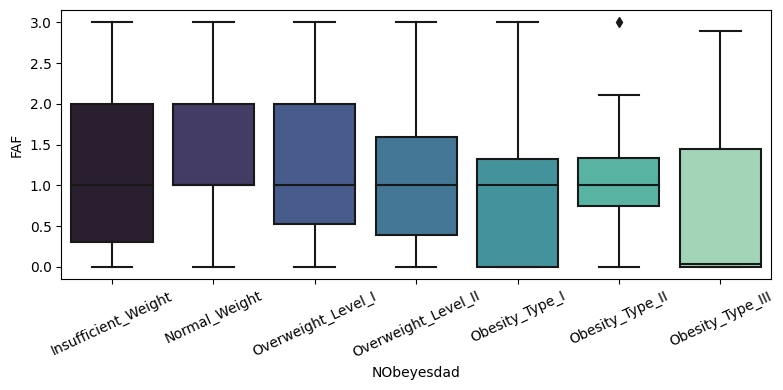

In [425]:
plt.figure(figsize=(8,4))
sns.boxplot(x='NObeyesdad', y='FAF', data=train_df, palette='mako',order=target_order)
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('faf2.png', transparent=True)


- The data suggests potential associations between obesity levels and frequency of engaging in physical activity. For example, lower activity levels may be more prevalent among individuals with higher obesity levels, while higher activity levels may be more common among those with lower obesity levels.

# Feature Engineering 

We could benefit from weight and height and create a BMI feature . It condenses the information from both weight and height into a single feature, which could simplify the model. Additionally, BMI is used in medical contexts and research studies as a reliable indicator of obesity.
- **BMI = kg/m2**

In [123]:
feat_eng_df = train_df.copy()
feat_eng_df_test = test_df.copy()

In [124]:
feat_eng_df.reset_index(drop=True, inplace=True)
feat_eng_df_test.reset_index(drop=True, inplace=True)

In [125]:
feat_eng_df['BMI'] = feat_eng_df['Weight'] / (feat_eng_df['Height']**2)
feat_eng_df['BMI']

0        30.778701
1        28.628792
2        17.283951
3        29.411765
4        35.568631
           ...    
16601    20.811655
16602    28.878563
16603    19.628265
16604    31.712712
16605    29.411765
Name: BMI, Length: 16606, dtype: float64

In [126]:
feat_eng_df_test['BMI'] = feat_eng_df_test['Weight'] / (feat_eng_df_test['Height']**2)
feat_eng_df_test['BMI']

0       22.100290
1       21.778435
2       36.728769
3       41.429532
4       31.680120
          ...    
4147    21.461937
4148    20.227026
4149    17.492242
4150    19.135346
4151    28.024832
Name: BMI, Length: 4152, dtype: float64

* **BMI Under 18.5** : Underweight.

* **BMI between 18.5 and 24.9** : Normal weight.

* **BMI between 25 and 29.9** : Overweight.

* **BMI Over 30** : Obese.

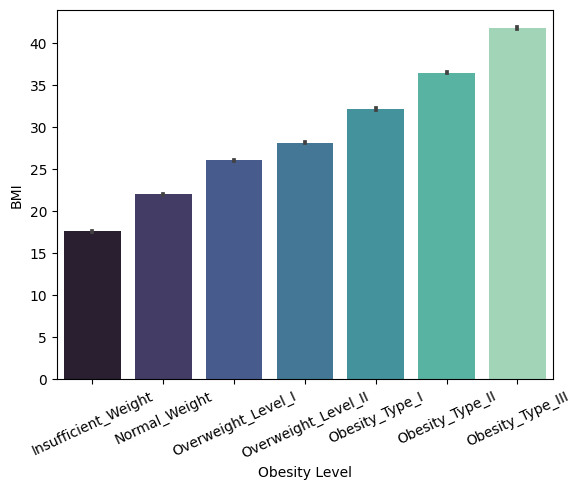

In [127]:
sns.barplot(x= 'NObeyesdad', y= 'BMI', data = feat_eng_df, order=target_order, palette='mako')
plt.xlabel('Obesity Level')
plt.xticks(rotation = 25);

- Logically, as the BMI increases ,the obesity level increases as well.

<Axes: >

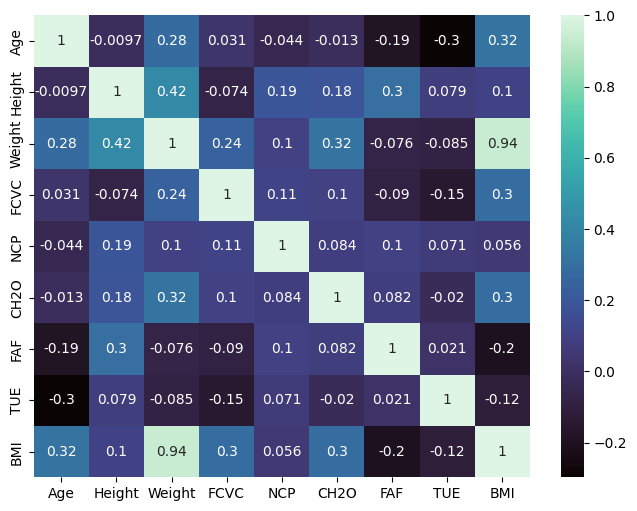

In [128]:
plt.figure(figsize=(8,6))
sns.heatmap(feat_eng_df.corr(numeric_only=True), annot=True, cmap='mako')

- High correlation between weight and BMI can lead to *Multicollinearity issues*. 
- *Multicollinearity* can make the model's interpretation less reliable. 
- Also, perhaps there is non-linear relationship between BMI and height, thus we could rid of height and weight columns.

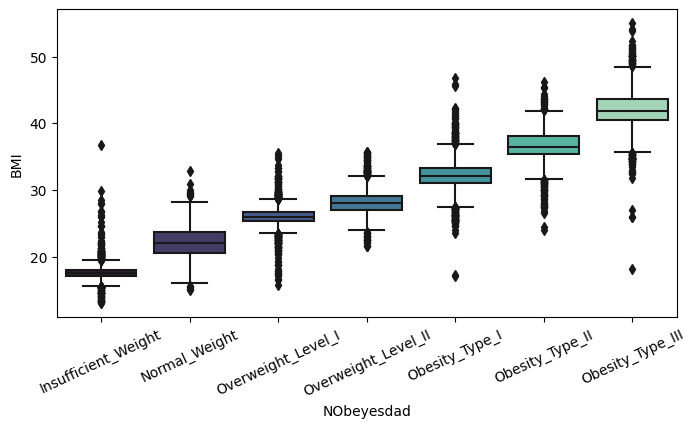

In [435]:
plt.figure(figsize=(8,4))
sns.boxplot(x='NObeyesdad', y='BMI', data=feat_eng_df, palette='mako',order=target_order)
plt.xticks(rotation=25);

- After training, we ultimately decided not to include the BMI feature in our model due to its poorer performance. 
- This decision was made considering potential issues such as overfitting or other underlying factors affecting its predictive power.

# Data Preprocessing

In [612]:
numerical_features = train_df.select_dtypes('number').columns
numerical_features

Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

In [613]:
categorical_features 

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')

In [614]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numerical_features), 
        ('categorical', OneHotEncoder(drop = 'if_binary'), categorical_features),
    ])

In [615]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [616]:
transformed_X = pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())
transformed_X_test = pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())

In [617]:
transformed_X.head()

,numeric__id,numeric__Age,numeric__Height,numeric__Weight,numeric__FCVC,numeric__NCP,numeric__CH2O,numeric__FAF,numeric__TUE,categorical__Gender_Male,...,categorical__SMOKE_yes,categorical__SCC_yes,categorical__CALC_Frequently,categorical__CALC_Sometimes,categorical__CALC_no,categorical__MTRANS_Automobile,categorical__MTRANS_Bike,categorical__MTRANS_Motorbike,categorical__MTRANS_Public_Transportation,categorical__MTRANS_Walking
0,-0.975938,-0.324671,0.114410,0.080848,-0.838072,-2.478371,-0.048656,0.028876,2.297650,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.404335,3.028261,-0.685698,-0.411159,1.039585,-2.478371,-0.048656,-1.167280,-1.024744,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.714290,-1.030552,1.143120,-1.205940,-0.838072,1.753176,-0.048656,1.225032,0.636453,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.281843,-1.030552,0.000109,-0.108385,-0.838072,0.342660,-0.048656,1.225032,0.636453,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.873735,-0.194908,1.708053,1.278998,-0.176530,-0.080535,0.540600,0.847743,0.203892,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [618]:
ord_encoder = OrdinalEncoder(categories = [target_order])
transformed_y = ord_encoder.fit_transform(y_train.array.reshape(-1,1)).astype(int)
transformed_y_test = ord_encoder.transform(y_test.array.reshape(-1,1)).astype(int)

In [619]:
ord_encoder.inverse_transform([[0],[1],[2],[3],[4],[5],[6]])

array([['Insufficient_Weight'],
       ['Normal_Weight'],
       ['Overweight_Level_I'],
       ['Overweight_Level_II'],
       ['Obesity_Type_I'],
       ['Obesity_Type_II'],
       ['Obesity_Type_III']], dtype=object)

In [620]:
num_transformed_X = transformed_X[['numeric__Age','numeric__Height','numeric__Weight','numeric__FCVC','numeric__NCP','numeric__CH2O','numeric__FAF','numeric__TUE']]

In [621]:
combined_df = pd.concat((num_transformed_X, pd.DataFrame(transformed_y,columns=['NObeyesdad'])), axis=1)
combined_df

,numeric__Age,numeric__Height,numeric__Weight,numeric__FCVC,numeric__NCP,numeric__CH2O,numeric__FAF,numeric__TUE,NObeyesdad
0,-0.324671,0.114410,0.080848,-0.838072,-2.478371,-0.048656,0.028876,2.297650,4
1,3.028261,-0.685698,-0.411159,1.039585,-2.478371,-0.048656,-1.167280,-1.024744,4
2,-1.030552,1.143120,-1.205940,-0.838072,1.753176,-0.048656,1.225032,0.636453,0
3,-1.030552,0.000109,-0.108385,-0.838072,0.342660,-0.048656,1.225032,0.636453,3
4,-0.194908,1.708053,1.278998,-0.176530,-0.080535,0.540600,0.847743,0.203892,5
...,...,...,...,...,...,...,...,...,...
16601,-0.148201,-1.714408,-1.433020,-0.838072,-2.478371,-1.694722,-1.167280,0.636453,1
16602,1.829042,-0.423057,-0.302783,-0.838072,-1.277898,-1.572834,-0.110426,-1.024744,2
16603,-0.501142,-1.371505,-1.470867,-0.838072,0.342660,-0.048656,1.225032,0.636453,0
16604,2.333604,-1.605057,-0.406117,-0.838072,0.270330,-0.828376,-1.167280,-1.024744,4


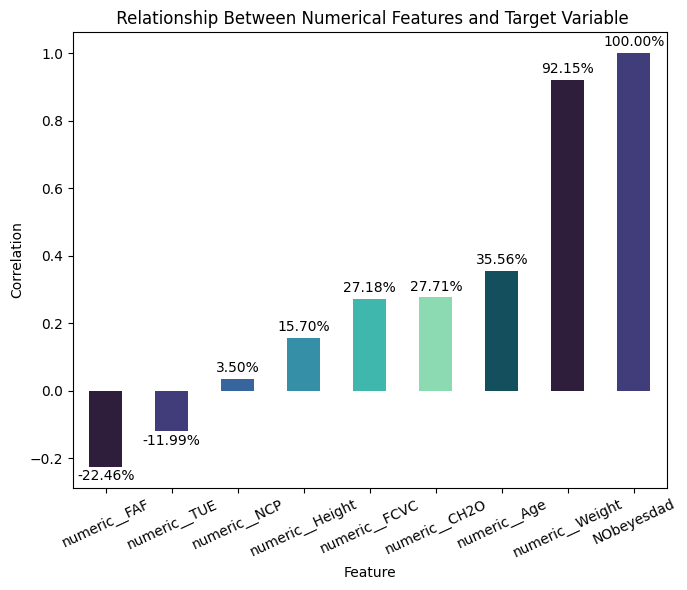

In [622]:
corr_values = combined_df.corr().sort_values('NObeyesdad')['NObeyesdad']

plt.figure(figsize=(7, 6))
ax = corr_values.plot(kind='bar', color=colors)

for i, v in enumerate(corr_values):
    if v<0 : 
        ax.text(i, v - 0.04, '{:.2f}%'.format(v * 100), ha='center')
    else:
        ax.text(i, v + 0.02, '{:.2f}%'.format(v * 100), ha='center')

plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title(' Relationship Between Numerical Features and Target Variable')
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('corr.png', transparent=True)
plt.show()

<Axes: >

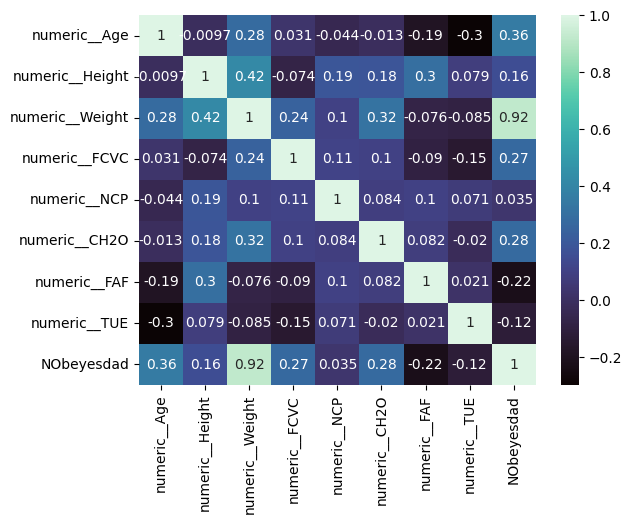

In [623]:
sns.heatmap(combined_df.corr(),annot=True,cmap='mako')

In [624]:
combined_df.corr().sort_values('NObeyesdad')['NObeyesdad']

numeric__FAF      -0.224637
numeric__TUE      -0.119912
numeric__NCP       0.034960
numeric__Height    0.157041
numeric__FCVC      0.271832
numeric__CH2O      0.277107
numeric__Age       0.355591
numeric__Weight    0.921546
NObeyesdad         1.000000
Name: NObeyesdad, dtype: float64

Age: There is a moderately strong positive correlation (approximately 0.356) between age and the obesity level. This suggests that as age increases, the likelihood of having a higher obesity level also increases.

BMI (Body Mass Index): There is a very strong positive correlation (approximately 0.961) between BMI and the obesity level. This is expected since BMI is a measure of body fat based on height and weight, and it's commonly used to classify obesity levels.

FAF (Frequency of engaging in physical activity): There is a moderate negative correlation (approximately -0.223) between the frequency of engaging in physical activity and the obesity level. This implies that individuals who engage in physical activity more frequently are less likely to have higher obesity levels.


# Data Modeling

## Logistic Regression

In [669]:
base_lr = LogisticRegression(penalty = None, multi_class='auto', random_state=42)
base_lr.fit(transformed_X,
            transformed_y)

LogisticRegression(penalty=None, random_state=42)

In [450]:
# Training Report
print('Training Report\n',classification_report(transformed_y , base_lr.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , base_lr.predict(transformed_X_test),digits=4))

Training Report
               precision    recall  f1-score   support

           0     0.8825    0.9376    0.9092      2018
           1     0.8582    0.8174    0.8373      2465
           2     0.7372    0.7106    0.7236      1942
           3     0.7223    0.7141    0.7182      2018
           4     0.8256    0.8359    0.8307      2328
           5     0.9421    0.9584    0.9502      2598
           6     0.9948    0.9978    0.9963      3237

    accuracy                         0.8668     16606
   macro avg     0.8518    0.8531    0.8522     16606
weighted avg     0.8657    0.8668    0.8660     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.8903    0.9485    0.9185       505
           1     0.8772    0.8217    0.8485       617
           2     0.7637    0.7196    0.7410       485
           3     0.7423    0.7202    0.7311       504
           4     0.8088    0.8505    0

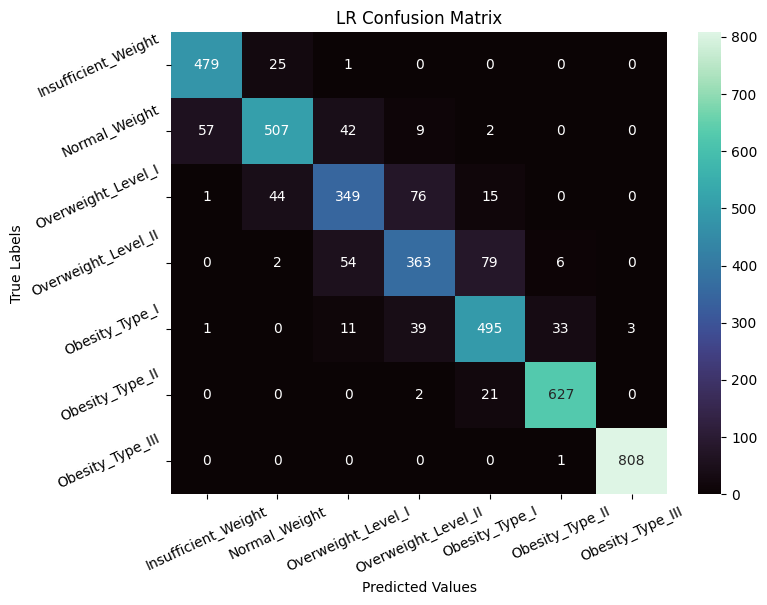

In [451]:
predictions = base_lr.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('LR Confusion Matrix')
plt.savefig('LRconfusionmatrix.png', transparent=True,bbox_inches='tight')

## Hyperparameters Tuning

In [ ]:
random_grid = {
    'C': [0.05, 0.1, 5, 20, 50, 100, 500, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 300,500],
}
f1scorer = make_scorer(f1_score, average='weighted')  # Takes into account class imbalance
estimator = LogisticRegression(random_state=42)
random_search = RandomizedSearchCV(estimator=estimator,param_distributions=random_grid, scoring=f1scorer, cv=5,verbose=4)
random_search.fit(transformed_X,
                  transformed_y)

In [670]:
best_params=random_search.best_params_
best_params

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'C': 1000}

In [671]:
lr_clf = LogisticRegression(**best_params, multi_class='auto', random_state=42)
lr_clf.fit(transformed_X,
        transformed_y)

LogisticRegression(C=1000, random_state=42)

In [455]:
# Training Report
print('Training Report\n',classification_report(transformed_y , lr_clf.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , lr_clf.predict(transformed_X_test),digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.8815    0.9366    0.9082      2018
           1     0.8560    0.8174    0.8363      2465
           2     0.7394    0.7085    0.7236      1942
           3     0.7236    0.7136    0.7186      2018
           4     0.8238    0.8376    0.8307      2328
           5     0.9417    0.9580    0.9498      2598
           6     0.9948    0.9978    0.9963      3237

    accuracy                         0.8666     16606
   macro avg     0.8516    0.8528    0.8519     16606
weighted avg     0.8653    0.8666    0.8657     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.8939    0.9505    0.9213       505
           1     0.8806    0.8250    0.8519       617
           2     0.7615    0.7175    0.7389       485
           3     0.7398    0.7163    0.7278       504
           4     0.8055    0.8540    0

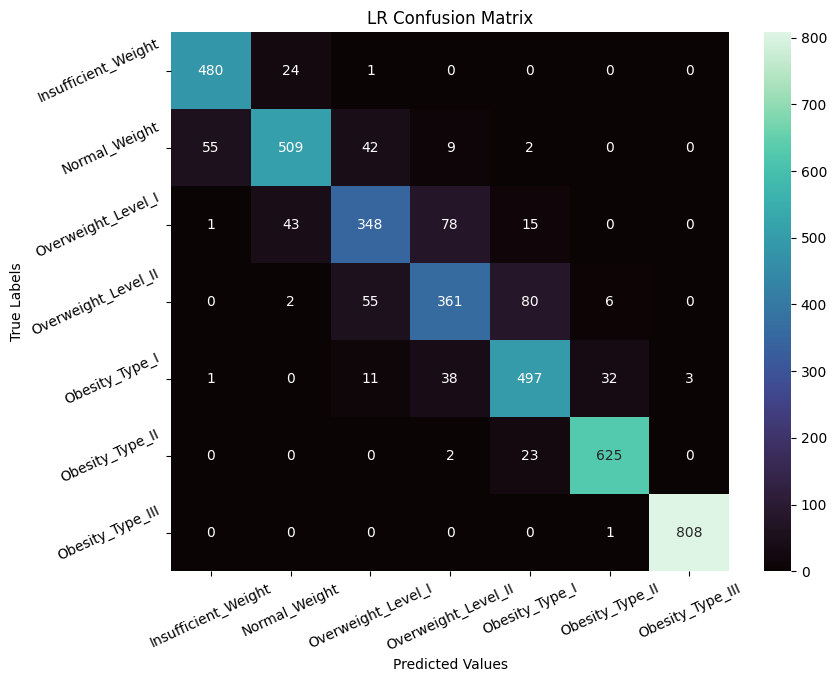

In [456]:
predictions = lr_clf.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(9, 7))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('LR Confusion Matrix')
plt.savefig('LRconfusionmatrix2.png', transparent=True,bbox_inches='tight')

### Hyperparameters tuning using Optuna

In [533]:
def objective_lr(trial):
    
    # Define the search space ranges for hyperparameters
    param_grid = {
        'C': trial.suggest_loguniform('C', 0.00001, 100)
    }
    
    estimator = LogisticRegression(max_iter=1000,n_jobs=-1,random_state=42)
    
    
    f1scorer = make_scorer(f1_score, average='weighted')
    
    scores = cross_val_score(estimator, transformed_X, transformed_y.reshape(-1), cv=5, scoring=f1scorer, n_jobs=-1)
    
    
    return scores.mean()

In [ ]:
# Create a study object and optimize the objective function using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, n_trials=100)

In [535]:
best_params = study.best_params
print("Best parameters found:", best_params)

Best parameters found: {'C': 2.9175680416791496}


In [536]:
lr_clf = LogisticRegression(**best_params, multi_class='auto', random_state=42)
lr_clf.fit(transformed_X,
            transformed_y)

LogisticRegression(C=2.9175680416791496, random_state=42)

In [537]:
# Training Report
print('Training Report\n',classification_report(transformed_y , lr_clf.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , lr_clf.predict(transformed_X_test),digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.8792    0.9376    0.9074      2018
           1     0.8531    0.8150    0.8336      2465
           2     0.7402    0.7029    0.7211      1942
           3     0.7231    0.7131    0.7181      2018
           4     0.8252    0.8333    0.8292      2328
           5     0.9377    0.9615    0.9494      2598
           6     0.9938    0.9978    0.9958      3237

    accuracy                         0.8655     16606
   macro avg     0.8503    0.8516    0.8507     16606
weighted avg     0.8640    0.8655    0.8645     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.8887    0.9485    0.9176       505
           1     0.8767    0.8185    0.8466       617
           2     0.7620    0.7196    0.7402       485
           3     0.7351    0.7103    0.7225       504
           4     0.8101    0.8505    0

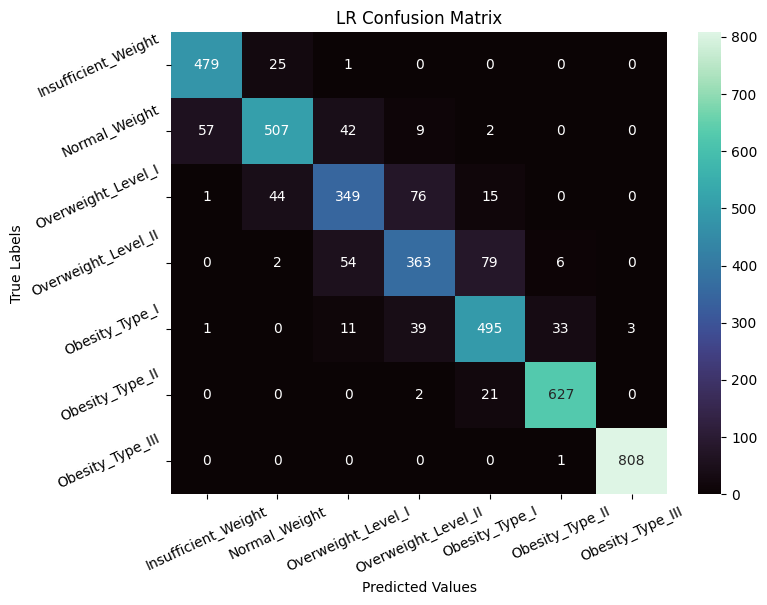

In [462]:
predictions = base_lr.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('LR Confusion Matrix')
plt.savefig('LRconfusionmatrix3.png', transparent=True)

## Decision Trees

In [463]:
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(transformed_X,
              transformed_y)

DecisionTreeClassifier(random_state=42)

In [464]:
base_tree.tree_.max_depth , base_tree.tree_.node_count, base_tree.tree_.n_leaves

(26, 4061, 2031)

In [465]:
# Training Report
print('Training Report\n',classification_report(transformed_y , base_tree.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , base_tree.predict(transformed_X_test),digits=4))
# Obvious Overfitting occured

Training Report
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2018
           1     1.0000    1.0000    1.0000      2465
           2     1.0000    1.0000    1.0000      1942
           3     1.0000    1.0000    1.0000      2018
           4     1.0000    1.0000    1.0000      2328
           5     1.0000    1.0000    1.0000      2598
           6     1.0000    1.0000    1.0000      3237

    accuracy                         1.0000     16606
   macro avg     1.0000    1.0000    1.0000     16606
weighted avg     1.0000    1.0000    1.0000     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.8856    0.8891    0.8874       505
           1     0.7928    0.7877    0.7902       617
           2     0.6722    0.6639    0.6680       485
           3     0.7010    0.7024    0.7017       504
           4     0.8078    0.8162    0

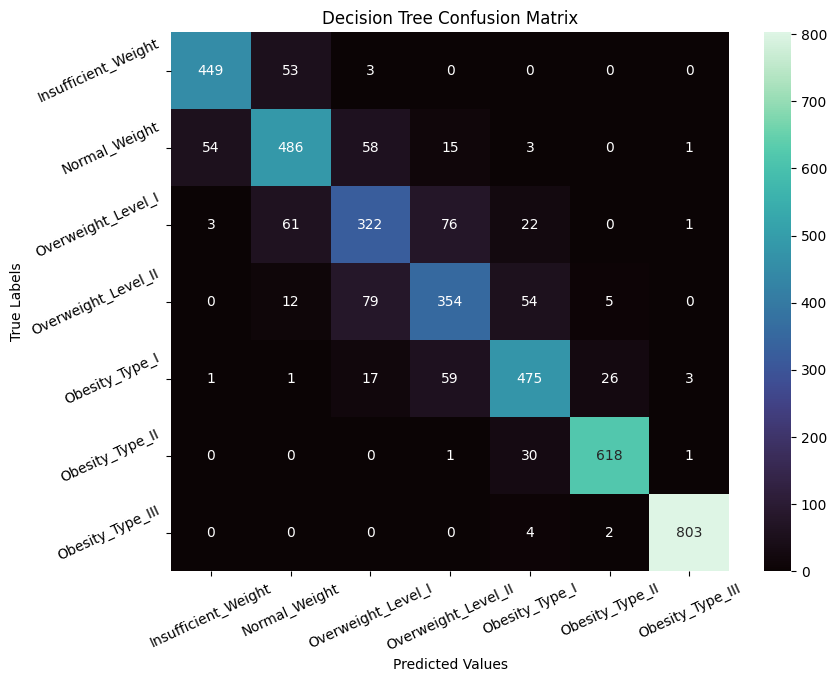

In [466]:
predictions = base_tree.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(9, 7))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('Decision Tree Confusion Matrix')
plt.savefig('DTcmatrix.png', transparent=True)

## Decision Trees with Hyperparameters Tuning

In [ ]:
random_grid = {'min_samples_split':[100,500,1000,3000,7000,10000],          # larger values means less complexity,more regularization
        'max_depth': [7,15,20,30,50],                            # larger values means more complexity,less regularization
        'min_samples_leaf': [100, 500, 1000, 2000, 3000, 4000],  # lower values means more complexity,less regularization
        'max_leaf_nodes': [100, 700,1500,5000,15000],            # larger values means more complexity,less regularization
        'max_features': [10,15,17]}                        # more features means more complexity,less regularization

estimator = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=estimator,param_distributions=random_grid,scoring=f1scorer,cv=5,verbose=4)
random_search.fit(transformed_X,
                  transformed_y)

In [468]:
random_search.best_params_

{'min_samples_split': 100,
 'min_samples_leaf': 100,
 'max_leaf_nodes': 700,
 'max_features': 17,
 'max_depth': 15}

In [483]:
def objective_tree(trial):
    
    # Define the search space ranges for hyperparameters
    param_grid = {
        'min_samples_split': trial.suggest_int('min_samples_split', 70,800),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 50, 300),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 100,1000),
        'max_features': trial.suggest_int('max_features', 7, 17),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'ccp_alpha': trial.suggest_loguniform('ccp_alpha', 0.000001, 0.001) 
    }

    estimator = DecisionTreeClassifier(**param_grid,
                                       random_state=42)
    
    
    f1scorer = make_scorer(f1_score, average='weighted')
    
    scores = cross_val_score(estimator, transformed_X, transformed_y, cv=5, scoring=f1scorer, n_jobs=-1)
    
    
    return scores.mean()

In [ ]:
# Create a study object and optimize the objective function using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_tree, n_trials=100)

In [675]:
best_params = study.best_params
print("Best parameters found:", best_params)

Best parameters found: {'min_samples_split': 70, 'min_samples_leaf': 50, 'max_leaf_nodes': 380, 'max_features': 17, 'max_depth': 87, 'ccp_alpha': 1.2439178669530549e-06}


In [676]:
tree_clf = DecisionTreeClassifier(**best_params,
                                  random_state=42)
tree_clf.fit(transformed_X,
            transformed_y)

DecisionTreeClassifier(ccp_alpha=1.2439178669530549e-06, max_depth=87,
                       max_features=17, max_leaf_nodes=380, min_samples_leaf=50,
                       min_samples_split=70, random_state=42)

In [487]:
# Training Report
print('Training Report\n',classification_report(transformed_y , tree_clf.predict(transformed_X), digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , tree_clf.predict(transformed_X_test), digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.8868    0.8969    0.8918      2018
           1     0.8033    0.8166    0.8099      2465
           2     0.7325    0.7024    0.7171      1942
           3     0.7432    0.7270    0.7350      2018
           4     0.8400    0.8436    0.8418      2328
           5     0.9388    0.9630    0.9508      2598
           6     0.9981    0.9929    0.9955      3237

    accuracy                         0.8632     16606
   macro avg     0.8490    0.8489    0.8489     16606
weighted avg     0.8622    0.8632    0.8626     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.8874    0.9050    0.8961       505
           1     0.7820    0.8023    0.7920       617
           2     0.6996    0.6577    0.6780       485
           3     0.7443    0.7163    0.7300       504
           4     0.8123    0.8402    0

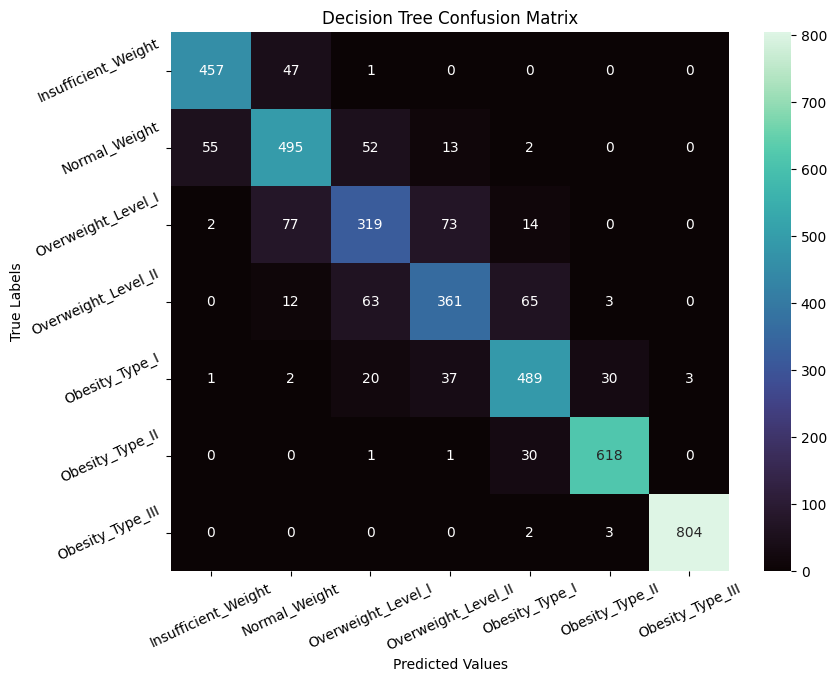

In [488]:
predictions = tree_clf.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(9, 7))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('Decision Tree Confusion Matrix')
plt.savefig('DTcmatrix2.png', transparent=True,bbox_inches='tight')

## Extracting Important Features using Decision Trees

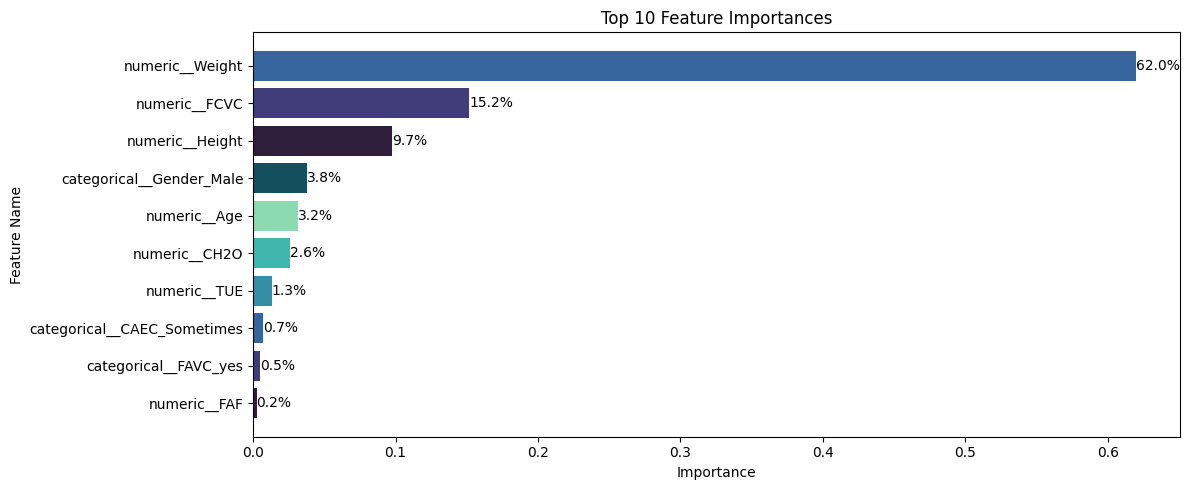

In [489]:
plt.figure(figsize=(12,5))
feature_importances = tree_clf.feature_importances_
sorted_indices = feature_importances.argsort()
sorted_importances = feature_importances[sorted_indices]
feature_names = transformed_X.columns

# top 10 important features
top_indices = sorted_indices[-10:]
top_importances = sorted_importances[-10:]
top_feature_names = [feature_names[i] for i in top_indices]

plt.barh(range(len(top_importances)), top_importances, color=colors)

for i, v in enumerate(top_importances):
    plt.text(v, i, '{:.1f}%'.format(v*100), va='center', ha='left')

plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.tight_layout() 
plt.savefig('top_feat_imp.png', transparent=True)
plt.show()


- In decision tree feature importance, Weight is the most impactful feature, followed by Frequency of consuming vegetables, Height, and so on. The features towards the left have negligible impact on the model's predictions.

## Random Forest

In [490]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(transformed_X,
             transformed_y)

RandomForestClassifier(random_state=42)

In [491]:
# Training Report
print('Training Report\n',classification_report(transformed_y , rf_base.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , rf_base.predict(transformed_X_test),digits=4))

Training Report
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2018
           1     1.0000    1.0000    1.0000      2465
           2     1.0000    1.0000    1.0000      1942
           3     1.0000    1.0000    1.0000      2018
           4     1.0000    1.0000    1.0000      2328
           5     1.0000    1.0000    1.0000      2598
           6     1.0000    1.0000    1.0000      3237

    accuracy                         1.0000     16606
   macro avg     1.0000    1.0000    1.0000     16606
weighted avg     1.0000    1.0000    1.0000     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.9302    0.9505    0.9403       505
           1     0.8585    0.8752    0.8668       617
           2     0.7982    0.7258    0.7603       485
           3     0.7810    0.7996    0.7902       504
           4     0.8857    0.8918    0

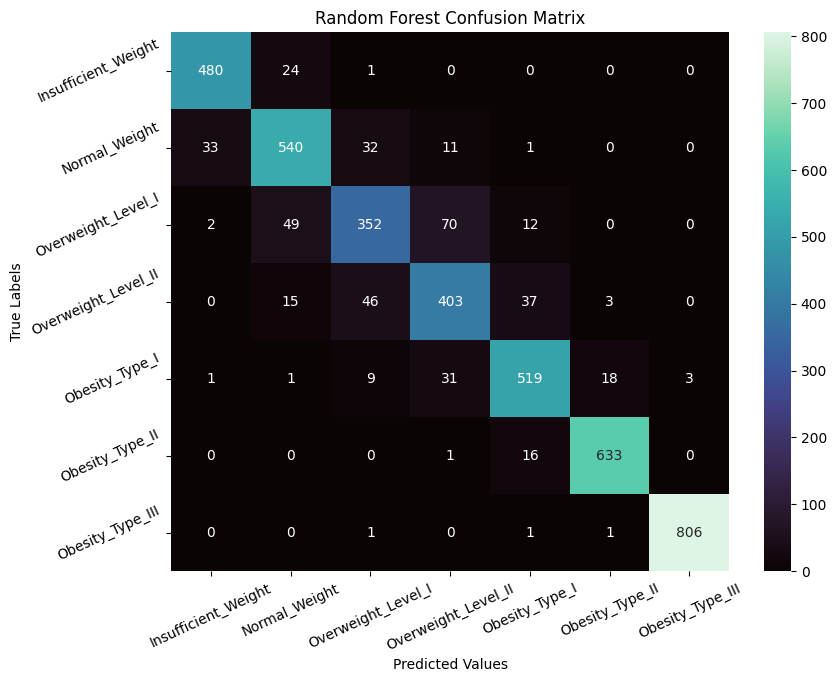

In [492]:
predictions = rf_base.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(9, 7))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.savefig('Rfcmatrix.png', transparent=True)

## Random Forest with Tuning Hyperparameters

In [496]:
random_grid = {'min_samples_split':[2,5,10,15,20],          # larger values means less complexity,more regularization
        'max_depth': [7,15,20,30,50],                            # larger values means more complexity,less regularization
        'min_samples_leaf': [5,10,100, 500, 1000],  # Increasing min_samples_leaf can increase regularization
        'max_leaf_nodes': [100, 700,1500,5000],            # larger values means more complexity,less regularization
        'max_features': [10,12,15,17]}                        # more features means more complexity,less regularization


estimator = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=estimator,
                                   param_distributions=random_grid,
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=7)
random_search.fit(transformed_X,
                  transformed_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [7, 15, 20, 30, 50],
                                        'max_features': [10, 12, 15, 17],
                                        'max_leaf_nodes': [100, 700, 1500,
                                                           5000],
                                        'min_samples_leaf': [5, 10, 100, 500,
                                                             1000],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              20]},
                   verbose=7)

In [497]:
random_search.best_params_

{'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 1500,
 'max_features': 15,
 'max_depth': 30}

In [ ]:
grid = {'min_samples_split':[17,20,25],                 # larger values means less complexity,more regularization
        'min_samples_leaf': [9,10,11],             # Increasing min_samples_leaf can increase regularization
        'max_leaf_nodes': [1450,1500,1550],            # larger values means more complexity,less regularization
        'max_features': [15,16,17],                         # more features means more complexity,less regularization
        'ccp_alpha': [0,0.00001,0.0001]}                        
estimator = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=estimator,
                                   param_grid=grid,
                                   cv=5,
                                   verbose=4)
grid_search.fit(transformed_X,
                transformed_y)

In [677]:
best_params = grid_search.best_params_
best_params 

{'ccp_alpha': 0.0001,
 'max_features': 16,
 'max_leaf_nodes': 1450,
 'min_samples_leaf': 9,
 'min_samples_split': 20}

In [678]:
rf_clf = RandomForestClassifier(**best_params)

rf_clf.fit(transformed_X,
           transformed_y)

RandomForestClassifier(ccp_alpha=0.0001, max_features=16, max_leaf_nodes=1450,
                       min_samples_leaf=9, min_samples_split=20)

In [506]:
# Training Report
print('Training Report\n',classification_report(transformed_y , rf_clf.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , rf_clf.predict(transformed_X_test),digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.9313    0.9400    0.9356      2018
           1     0.8820    0.8941    0.8880      2465
           2     0.8334    0.7987    0.8157      1942
           3     0.8307    0.8484    0.8394      2018
           4     0.9077    0.8956    0.9016      2328
           5     0.9690    0.9750    0.9720      2598
           6     0.9975    0.9975    0.9975      3237

    accuracy                         0.9160     16606
   macro avg     0.9074    0.9070    0.9071     16606
weighted avg     0.9158    0.9160    0.9158     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.9300    0.9465    0.9382       505
           1     0.8592    0.8801    0.8695       617
           2     0.8072    0.7423    0.7734       485
           3     0.7965    0.8075    0.8020       504
           4     0.8729    0.8849    0

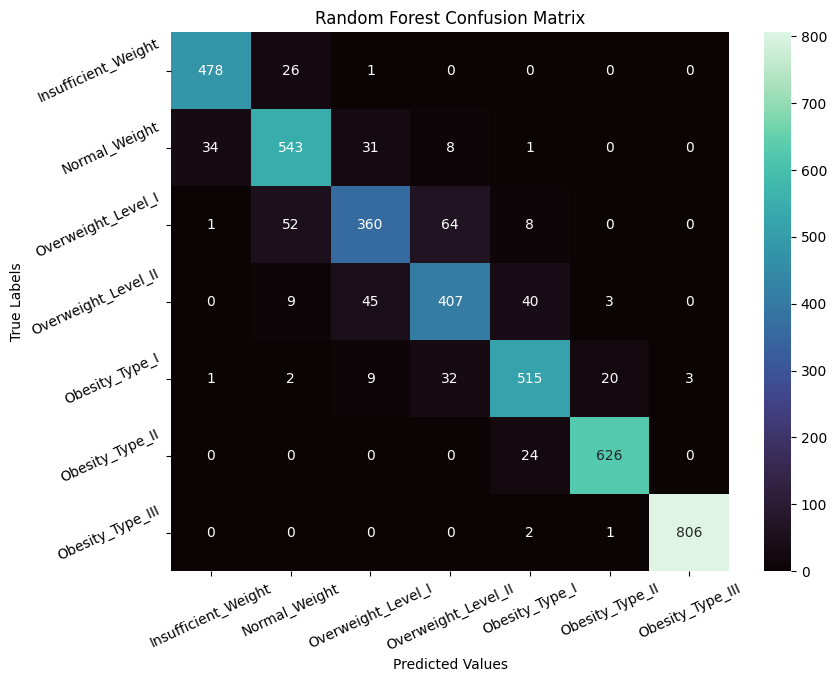

In [507]:
predictions = rf_clf.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(9, 7))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.savefig('Rfcmatrix2.png', transparent=True,bbox_inches='tight')

## XGBoost

In [625]:
base_xgb = xgb.XGBClassifier(objective='multi:softmax',seed=42)
base_xgb.fit(transformed_X,
             transformed_y,
             verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [626]:
# Training Report
print('Training Report\n',classification_report(transformed_y , base_xgb.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , base_xgb.predict(transformed_X_test),digits=4))

Training Report
               precision    recall  f1-score   support

           0     0.9960    0.9970    0.9965      2018
           1     0.9871    0.9931    0.9901      2465
           2     0.9839    0.9763    0.9801      1942
           3     0.9876    0.9851    0.9864      2018
           4     0.9949    0.9961    0.9955      2328
           5     1.0000    1.0000    1.0000      2598
           6     1.0000    1.0000    1.0000      3237

    accuracy                         0.9935     16606
   macro avg     0.9928    0.9925    0.9927     16606
weighted avg     0.9935    0.9935    0.9935     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.9320    0.9505    0.9412       505
           1     0.8806    0.8849    0.8828       617
           2     0.8224    0.7732    0.7970       485
           3     0.8112    0.8353    0.8231       504
           4     0.8918    0.8918    0

In [627]:
base_xgb.score(transformed_X_test, transformed_y_test)

0.9101637764932563

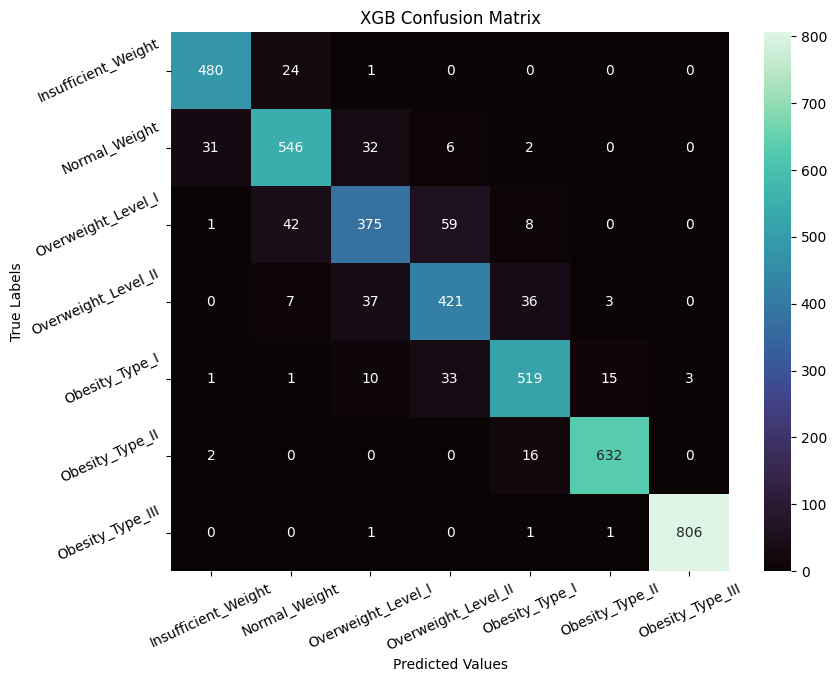

In [628]:
predictions = base_xgb.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(9, 7))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('XGB Confusion Matrix')
plt.savefig('xgbcmatrix.png', transparent=True,bbox_inches='tight')

### Extracting Important Features

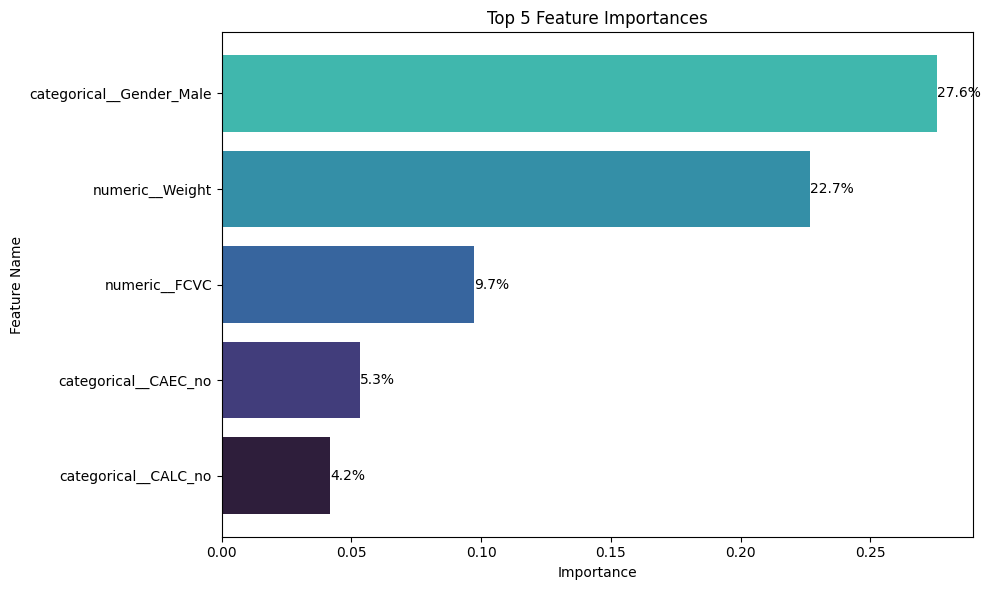

In [629]:
plt.figure(figsize=(10,6))
feature_importances = base_xgb.feature_importances_
sorted_indices = feature_importances.argsort()
sorted_importances = feature_importances[sorted_indices]
feature_names = transformed_X.columns

# the top 5 important features
top_indices = sorted_indices[-5:]
top_importances = sorted_importances[-5:]
top_feature_names = [feature_names[i] for i in top_indices]

plt.barh(range(len(top_importances)), top_importances, color=colors)

for i, v in enumerate(top_importances):
    plt.text(v, i, '{:.1f}%'.format(v*100), va='center', ha='left')

plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Top 5 Feature Importances')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.tight_layout() 
plt.savefig('top_feat_imp.png', transparent=True)
plt.show()


- Gender is the most impactful feature, followed by Weight, Frequency of consuming Food between the meals, Frequency of consuming alcohol, and so on. 
- almost all the features have an impact on the model's predictions.

- We could drop the least important feature (smoke)

In [630]:
transformed_X.drop('categorical__SMOKE_yes' , axis =1 , inplace=True)
transformed_X_test.drop('categorical__SMOKE_yes' , axis =1 , inplace=True)

## XGBoost with Hyperparameters Tuning

XGboost has a lot of hyperparameters, parameters that we have to manual configure and are not determined by XGBoost itself, including max_depth, the maximum tree depth, learning rate, or 'eta',gamma, the parameter that encourages pruning,and reg_lambda , the regularization parameter lambda.
So we will try to find the optimal values for these hyperparametes hopefully we can improve the accuracy with Testing Dataset.

In [631]:
f1scorer = make_scorer(f1_score, average='weighted')

### Random search

In [ ]:
param_grid = {
    'max_depth':[4,6,8,10],
    'learning_rate': [0.1, 0.01,0.05,1],
    'gamma':[0,0.25,0.5,1],
    'reg_lambda':[0,0.5,1,5,10]
    }

estimator = xgb.XGBClassifier(objective='multi:softmax',subsample=0.9,colsample_bytree=0.7,seed=42) #in order to speed up

random_search = RandomizedSearchCV(estimator=estimator,
                   param_distributions=param_grid,
                   scoring=f1scorer,
                   n_iter=50,  
                   cv=5,
                   verbose=2,
                   random_state=42,
                   n_jobs=-1)

random_search.fit(transformed_X,
                  transformed_y)


In [533]:
random_search.best_params_

{'reg_lambda': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.5}

### Grid search

In [ ]:
param_grid = {
    'max_depth':[5,6,7,8],
    'learning_rate': [0.08,0.1,0.2],
    'gamma':[0.4,0.5,0.55,0.6],
    'reg_lambda':[0.8,1,1.2]
    }

estimator = xgb.XGBClassifier(objective='multi:softmax',subsample=0.9,colsample_bytree=0.5,seed=42) #in order to speed up 

grid_search = GridSearchCV(estimator=estimator,
                   param_grid=param_grid,
                   scoring=f1scorer, 
                   cv=5,
                   verbose=4,
                   n_jobs=-1)

grid_search.fit(transformed_X,
                transformed_y)


In [517]:
best_params = grid_search.best_params_

In [ ]:
clf_xgb =  xgb.XGBClassifier(objective='multi:softmax',
                             **best_params,
                             subsample=0.9,
                             colsample_bytree=0.7,
                             seed=42)
clf_xgb.fit(transformed_X,
            transformed_y,
            early_stopping_rounds=10,
            eval_metric='mlogloss',
            eval_set=[(transformed_X_test,transformed_y_test)])

In [519]:
# Training Report
print('Training Report\n',classification_report(transformed_y , clf_xgb.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , clf_xgb.predict(transformed_X_test),digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.9612    0.9708    0.9660      2018
           1     0.9320    0.9448    0.9384      2465
           2     0.9152    0.8831    0.8988      1942
           3     0.9165    0.9242    0.9203      2018
           4     0.9594    0.9540    0.9567      2328
           5     0.9870    0.9911    0.9891      2598
           6     0.9985    0.9981    0.9983      3237

    accuracy                         0.9572     16606
   macro avg     0.9528    0.9523    0.9525     16606
weighted avg     0.9571    0.9572    0.9571     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.9354    0.9465    0.9409       505
           1     0.8826    0.8898    0.8862       617
           2     0.8212    0.7670    0.7932       485
           3     0.8035    0.8274    0.8152       504
           4     0.8937    0.8952    0

Text(83.22222222222221, 0.5, 'True Labels')

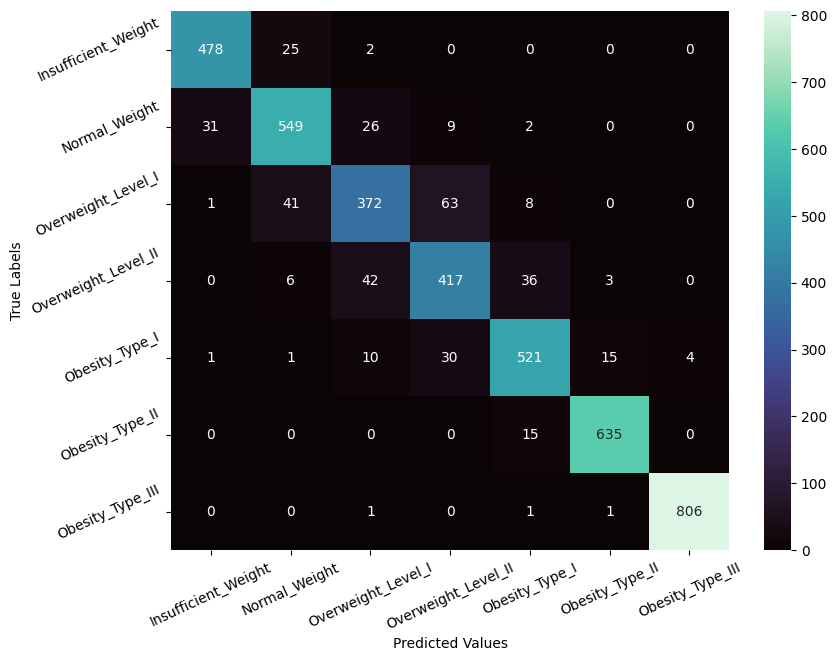

In [520]:
predictions =clf_xgb.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(9, 7))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)

plt.xlabel('Predicted Values')
plt.ylabel('True Labels')

### Hyperparamter Tuning Using Optuna

In [637]:
def objective(trial):
    
    # Define the search space ranges for hyperparameters
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 2.0),
        'gamma': trial.suggest_float('gamma', 0.0, 3.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 5),
        'n_estimators': trial.suggest_int('n_estimators', 800, 1000),
        'subsample': trial.suggest_float('subsample', 0.3,0.9),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.3,0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 21),
        
    }
    
    estimator = xgb.XGBClassifier(
        objective='multi:softmax',
        booster = 'gbtree',
        grow_policy = 'depthwise',
        **param_grid,
        seed=42
    )
    
    
    f1scorer = make_scorer(f1_score, average='weighted')
    
    scores = cross_val_score(estimator, transformed_X, transformed_y, cv=5, scoring=f1scorer, n_jobs=-1)
    
    
    return scores.mean()

In [ ]:
# Create a study object and optimize the objective function using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

In [639]:
best_params = study.best_params
print("Best parameters found:", best_params)

Best parameters found: {'max_depth': 14, 'learning_rate': 0.018163693269578122, 'gamma': 0.7487372044763971, 'reg_lambda': 0.47329556316341825, 'n_estimators': 912, 'subsample': 0.7654090048187816, 'colsample_bytree': 0.4153476791936009, 'min_child_weight': 14}


In [ ]:
xgb_clf =  xgb.XGBClassifier(objective='multi:softmax',
                                **best_params,
                                 grow_policy = 'depthwise',
                                 booster = 'gbtree',
                                 seed=42)
xgb_clf.fit(transformed_X,
            transformed_y,
            early_stopping_rounds=10,
            eval_metric='mlogloss',
            eval_set=[(transformed_X_test,transformed_y_test)],
            )

In [654]:
# Training Report
print('Training Report\n',classification_report(transformed_y , xgb_clf.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , xgb_clf.predict(transformed_X_test),digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.9518    0.9584    0.9551      2018
           1     0.9161    0.9306    0.9233      2465
           2     0.8857    0.8538    0.8694      1942
           3     0.8902    0.8959    0.8931      2018
           4     0.9349    0.9317    0.9333      2328
           5     0.9782    0.9827    0.9804      2598
           6     0.9972    0.9972    0.9972      3237

    accuracy                         0.9421     16606
   macro avg     0.9363    0.9358    0.9360     16606
weighted avg     0.9419    0.9421    0.9419     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.9318    0.9465    0.9391       505
           1     0.8816    0.8930    0.8873       617
           2     0.8359    0.7773    0.8056       485
           3     0.8170    0.8413    0.8289       504
           4     0.9050    0.9003    0

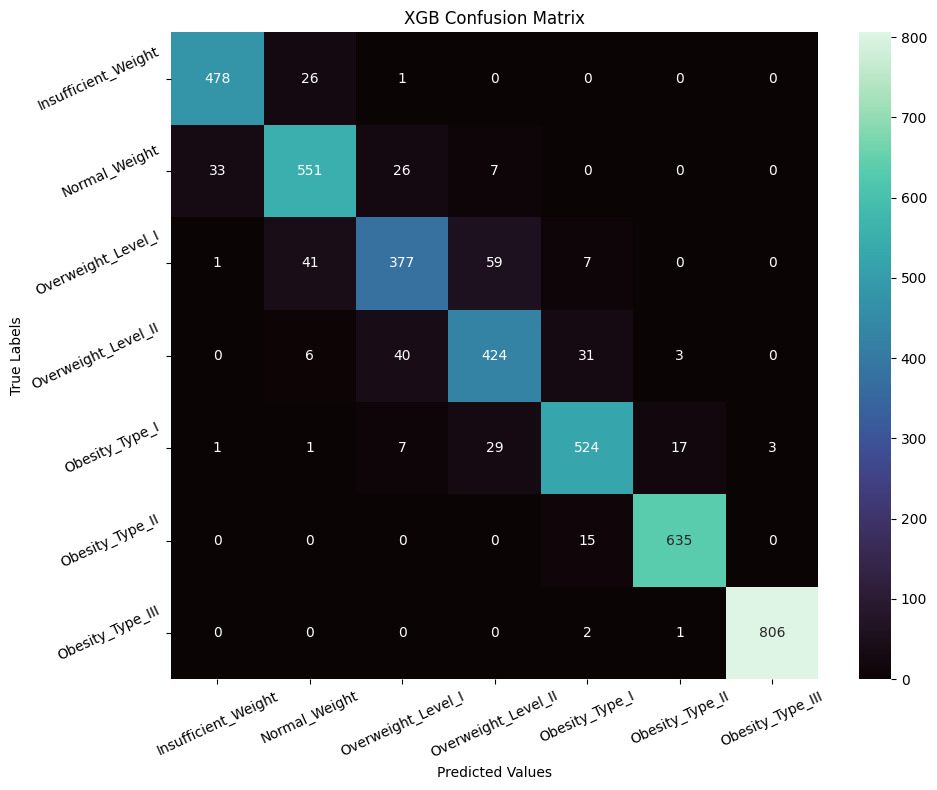

In [644]:
predictions = xgb_clf.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('XGB Confusion Matrix')
plt.tight_layout()
plt.savefig('confusionmatrix.png', transparent=True)

Overweight level I and overweight level II classes are often confused with each other, due to their proximity in terms of BMI.

In [647]:
one_tree_params = {'max_depth': 14,
 'learning_rate': 0.018163693269578122,
 'gamma': 0.7487372044763971,
 'reg_lambda': 0.47329556316341825,
 'n_estimators': 1,         # build one tree only
 'subsample': 0.7654090048187816,
 'colsample_bytree': 0.4153476791936009,
 'min_child_weight': 14}

In [651]:
onetree_xgb =  xgb.XGBClassifier(objective='multi:softmax',
                                **one_tree_params,
                                 seed=42) 
onetree_xgb.fit(transformed_X,
            transformed_y,
            early_stopping_rounds=10,
            eval_metric='mlogloss',
            eval_set=[(transformed_X_test,transformed_y_test)])

[0]	validation_0-mlogloss:1.91013


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4153476791936009, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.7487372044763971,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.018163693269578122,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=14, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

weight:  {'numeric__id': 35.0, 'numeric__Age': 46.0, 'numeric__Height': 28.0, 'numeric__Weight': 48.0, 'numeric__FCVC': 12.0, 'numeric__NCP': 6.0, 'numeric__CH2O': 27.0, 'numeric__FAF': 6.0, 'numeric__TUE': 24.0, 'categorical__Gender_Male': 16.0, 'categorical__family_history_with_overweight_yes': 9.0, 'categorical__FAVC_yes': 1.0, 'categorical__CAEC_Frequently': 12.0, 'categorical__CAEC_Sometimes': 3.0, 'categorical__CAEC_no': 1.0, 'categorical__CALC_Frequently': 1.0, 'categorical__CALC_Sometimes': 3.0, 'categorical__CALC_no': 3.0, 'categorical__MTRANS_Automobile': 5.0, 'categorical__MTRANS_Public_Transportation': 10.0}
gain:  {'numeric__id': 2.553750991821289, 'numeric__Age': 68.85261535644531, 'numeric__Height': 34.63359451293945, 'numeric__Weight': 288.5611877441406, 'numeric__FCVC': 59.54909133911133, 'numeric__NCP': 76.13201904296875, 'numeric__CH2O': 49.21906661987305, 'numeric__FAF': 10.921852111816406, 'numeric__TUE': 114.56307983398438, 'categorical__Gender_Male': 24.756237030

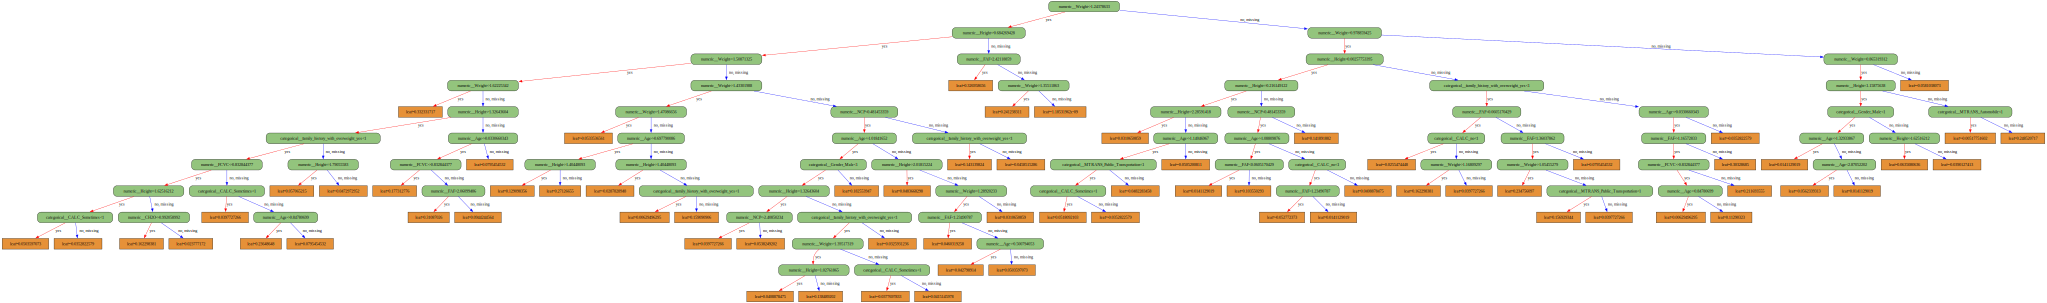

In [652]:
bst = onetree_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', 
'style': 'filled, rounded',
'fillcolor': '#93c47d'}
leaf_params = {'shape': 'box',
'style': 'filled',
'fillcolor': '#e69138'}

xgb_graph  = xgb.to_graphviz(clf_xgb, num_trees=0, size="5,5",
condition_node_params=node_params,
leaf_node_params=leaf_params)
xgb_graph.render("xgb_graph", format="png", cleanup=True)
xgb_graph

### In the XGBoost Tree, we have in each node:

- The feature (column name) and the threshold for splitting the observations. For example, in the tree's root node, we use
Weight to split the observations. All observations with Weight < -1.2 (scaled) go to the
left and all observations with Weight>= -1.2 go to the right.
- Each branch either says yes or no and some also say missing.
-  yes and no refer to whether the threshold in the node above it is true or not. If so, then yes, if not, then no.
- leaf tells us the raw score output value  for each leaf ,until it further processed into probabilities by softmax.

## Voting Classifier

In [683]:
voting_clf = VotingClassifier(
    
    estimators = [ 
            ('Model_1_LR', lr_clf),
            ('Model_2_RF', rf_clf),
            ('Model_3_XGBoost', xgb_clf)
            ], 
            voting='hard',
            verbose =2
            )

voting_clf.fit(transformed_X,transformed_y)

[Voting] ............... (1 of 3) Processing Model_1_LR, total=   0.8s
[Voting] ............... (2 of 3) Processing Model_2_RF, total=   5.8s
[Voting] .......... (3 of 3) Processing Model_3_XGBoost, total=  14.4s


VotingClassifier(estimators=[('Model_1_LR',
                              LogisticRegression(C=1000, random_state=42)),
                             ('Model_2_RF',
                              RandomForestClassifier(ccp_alpha=0.0001,
                                                     max_features=16,
                                                     max_leaf_nodes=1450,
                                                     min_samples_leaf=9,
                                                     min_samples_split=20)),
                             ('Model_3_XGBoost',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsa...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.018163693269578122,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=14,
                                            max_leaves=None,
                                            min_child_weight=14, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=912, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...))],
                 verbose=2)

In [684]:
# Training Report
print('Training Report\n',classification_report(transformed_y , voting_clf.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , voting_clf.predict(transformed_X_test),digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.9320    0.9514    0.9416      2018
           1     0.8966    0.9039    0.9002      2465
           2     0.8548    0.8244    0.8393      1942
           3     0.8582    0.8667    0.8624      2018
           4     0.9169    0.9055    0.9112      2328
           5     0.9713    0.9773    0.9743      2598
           6     0.9975    0.9975    0.9975      3237

    accuracy                         0.9258     16606
   macro avg     0.9182    0.9181    0.9181     16606
weighted avg     0.9256    0.9258    0.9256     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.9231    0.9505    0.9366       505
           1     0.8784    0.8784    0.8784       617
           2     0.8230    0.7670    0.7940       485
           3     0.8176    0.8274    0.8225       504
           4     0.8801    0.8952    0

Text(0.5, 1.0, 'Voting classifier Confusion Matrix')

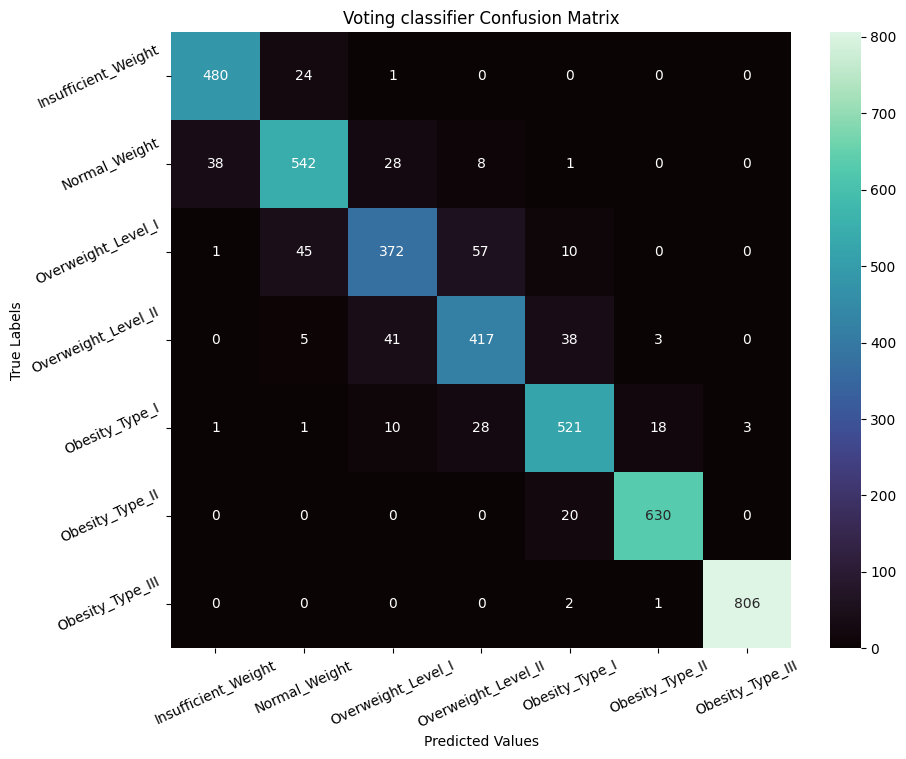

In [686]:
predictions = voting_clf.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)

plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('Voting classifier Confusion Matrix')

In [687]:
voting_clf = VotingClassifier(
    
    estimators = [ 
            ('Model_1_LR', lr_clf),
            ('Model_2_RF', rf_clf),
            ('Model_3_XGBoost', xgb_clf)
            ], 
            voting='soft',
            verbose =2
            )

voting_clf.fit(transformed_X,transformed_y)

[Voting] ............... (1 of 3) Processing Model_1_LR, total=   0.8s
[Voting] ............... (2 of 3) Processing Model_2_RF, total=   5.9s
[Voting] .......... (3 of 3) Processing Model_3_XGBoost, total=  15.9s


VotingClassifier(estimators=[('Model_1_LR',
                              LogisticRegression(C=1000, random_state=42)),
                             ('Model_2_RF',
                              RandomForestClassifier(ccp_alpha=0.0001,
                                                     max_features=16,
                                                     max_leaf_nodes=1450,
                                                     min_samples_leaf=9,
                                                     min_samples_split=20)),
                             ('Model_3_XGBoost',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsa...
                                            interaction_constraints=None,
                                            learning_rate=0.018163693269578122,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=14,
                                            max_leaves=None,
                                            min_child_weight=14, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=912, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...))],
                 verbose=2, voting='soft')

In [688]:
# Training Report
print('Training Report\n',classification_report(transformed_y , voting_clf.predict(transformed_X),digits=4))
print('_'*60)
# Testing Report
print('Testing Report\n',classification_report(transformed_y_test , voting_clf.predict(transformed_X_test),digits=4))


Training Report
               precision    recall  f1-score   support

           0     0.9304    0.9534    0.9418      2018
           1     0.9002    0.9006    0.9004      2465
           2     0.8548    0.8151    0.8345      1942
           3     0.8481    0.8657    0.8568      2018
           4     0.9147    0.9029    0.9088      2328
           5     0.9691    0.9781    0.9736      2598
           6     0.9966    0.9975    0.9971      3237

    accuracy                         0.9241     16606
   macro avg     0.9163    0.9162    0.9161     16606
weighted avg     0.9238    0.9241    0.9239     16606

____________________________________________________________
Testing Report
               precision    recall  f1-score   support

           0     0.9286    0.9525    0.9404       505
           1     0.8889    0.8817    0.8853       617
           2     0.8230    0.7670    0.7940       485
           3     0.8069    0.8294    0.8180       504
           4     0.8842    0.8918    0

Text(0.5, 1.0, 'Voting classifier Confusion Matrix')

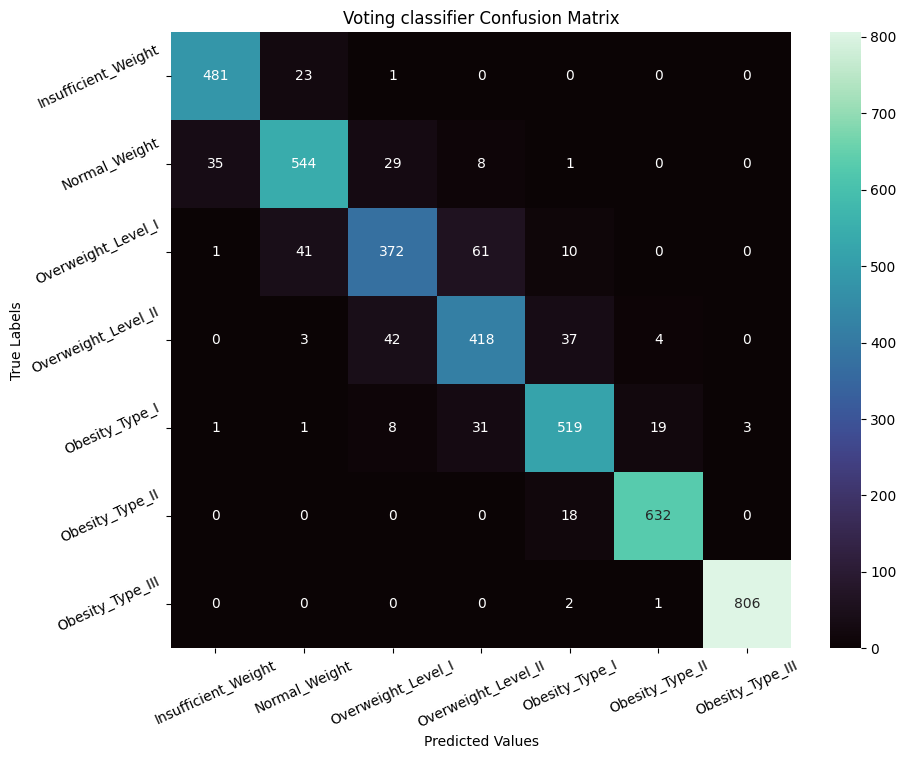

In [689]:
predictions = voting_clf.predict(transformed_X_test)
cm = confusion_matrix(y_pred=predictions,y_true=transformed_y_test)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm,fmt='d',annot=True,cmap='mako')
ax.set_xticklabels(target_order, rotation=25)
ax.set_yticklabels(target_order, rotation=25)

plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.title('Voting classifier Confusion Matrix')

## We Will go for the XGBOOST as our final model

# Preparing the Test set

In [655]:
test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [656]:
test.isna().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

In [657]:
train_df['CALC'].unique()

array(['Sometimes', 'no', 'Frequently'], dtype=object)

In [658]:
test['CALC'].unique()
# There seems to be an inconsistency between the categories present in the training set and the test set for the 'CALC' column.

array(['Sometimes', 'no', 'Frequently', 'Always'], dtype=object)

In [659]:
test['CALC'].replace('Always','Frequently',inplace=True)

In [660]:
(test[test['CALC']=='Always']['CALC']).sum()

0

In [566]:
# Let's remove the 'id' feature
# test.drop('id', axis=1, inplace = True)

In [661]:
test_encoded = pd.DataFrame(preprocessor.transform(test), columns = preprocessor.get_feature_names_out())

In [662]:
test_encoded.head()

,numeric__id,numeric__Age,numeric__Height,numeric__Weight,numeric__FCVC,numeric__NCP,numeric__CH2O,numeric__FAF,numeric__TUE,categorical__Gender_Male,...,categorical__SMOKE_yes,categorical__SCC_yes,categorical__CALC_Frequently,categorical__CALC_Sometimes,categorical__CALC_no,categorical__MTRANS_Automobile,categorical__MTRANS_Bike,categorical__MTRANS_Motorbike,categorical__MTRANS_Public_Transportation,categorical__MTRANS_Walking
0,1.727773,0.540012,1.695126,1.240629,0.924327,0.342660,1.310385,-0.144088,-1.024744,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.727939,-0.501142,-1.142903,-0.827473,-0.838072,-2.478371,1.597411,0.028876,-1.024744,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.728106,0.381209,-0.647350,0.898358,1.039585,0.342660,0.974995,-1.167280,-0.608611,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.728272,-0.504803,-1.678666,0.598179,-0.838072,0.311500,1.245839,-1.053823,-1.024744,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.728439,0.381209,-0.829763,0.642317,1.039585,0.342660,1.027100,-1.167280,0.206317,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [663]:
test_encoded.drop('categorical__SMOKE_yes' , axis =1 , inplace=True)

In [664]:
predictions = xgb_clf.predict(test_encoded)

In [665]:
labels = pd.DataFrame(ord_encoder.inverse_transform(predictions.reshape(-1,1)),columns=['NObeyesdad'])

In [666]:
final_predicitons= pd.concat((test['id'],labels),axis=1)

In [667]:
final_predicitons.to_csv('submission.csv',index=False)
final_predicitons

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


# Conclusion

### Summary comparison of the overall performance metrics (weighted average) for each model:

| Model              | Precision | Recall | F1-Score | Accuracy |
|--------------------|-----------|--------|----------|----------|
| Logistic Regression|   0.8727  | 0.8738 |  0.8728  |  0.8738  |
| Decision Trees     |   0.8521  | 0.8533 |  0.8526  |  0.8533  |
| Random Forest      |   0.8990  | 0.8996 |  0.8991  |  0.8996  |
| XGBoost            |   0.9137  | 0.9140 |  0.9137  |  0.9140  |
| Voting Classifier  |   0.9080  | 0.9085 |  0.9081  |  0.9085  |


- Logistic Regression:
This model achieves decent precision, recall, and F1-score, indicating balanced performance across the classes.
The accuracy is also consistent with the F1-score, suggesting reliable overall performance.

- Decision Trees:
Decision Trees show slightly lower performance compared to Logistic Regression in terms of precision, recall, and F1-score.
However, the accuracy is still high, indicating effective classification by the model.

- Random Forest:

Random Forest performs better than Decision Trees, with higher precision, recall, and F1-score, indicating improved performance in handling the dataset's complexity.
The accuracy is also higher, suggesting better overall performance compared to Decision Trees.

- XGBoost:

XGBoost demonstrates the highest precision, recall, and F1-score among all models, indicating superior performance in classifying obesity levels.
The accuracy is also the highest, suggesting that XGBoost provides the most reliable predictions compared to other models.

- Voting Classifier:

The Voting Classifier achieves similar performance to XGBoost in terms of precision, recall, F1-score, and accuracy.
This ensemble model combines multiple base models, potentially enhancing performance through diversity in predictions.